In [409]:
%load_ext autoreload
%autoreload 2
import sys, os, glob, re, pickle, scipy
from collections import defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from openbabel import openbabel as ob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

sys.path.append('/net/pulsar/home/koes/mtr22/param_search')
import param_search

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/net/pulsar/home/koes/mtr22/gan'

In [460]:
def find_work_dirs():
    '''
    Return mapping of job ids to works dirs
    based on stdout and stderr files.
    '''
    work_dir_pat = re.compile(r'^(.+)/(\d+)\.(stdout|stderr)$')
    work_dir_map = defaultdict(lambda: None)
    for f in glob.glob('*/*.std*'):
        m = work_dir_pat.match(f)
        if m:
            work_dir = m.group(1)
            job_id = int(m.group(2))
            if job_id in work_dir_map:
                assert work_dir_map[job_id] == work_dir
            else:
                work_dir_map[job_id] = work_dir
    return work_dir_map

def find_work_dir(x):
    '''
    If jobs are in queue, use the qstat value.
    Otherwise use the work_dir_map.
    '''
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

def find_job_state(x):
    '''
    If jobs are in the queue, use qstat value.
    Else if there's no work dir, assume the job
    was cancelled. If there's stderr, has error.
    '''
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0]) if len(x) == 3 else 0
    minutes = int(x[-2]) if len(x) >= 2 else 0
    seconds = int(x[-1])
    return dt.timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

def get_palette(n_hues, n_shades=1, n_repeat=1, hues=None, min_val=0.0, max_val=1.0, n_samples=100, mode=None):
    assert 0 <= min_val <= 1.0
    assert 0 <= max_val <= 1.0
    
    if hues is None:
        if n_hues <= 9:
            mode = mode or 'muted'
            hues = sns.color_palette(mode)[:n_hues]
        else:
            mode = mode or 'husl'
            hues = sns.color_palette(mode, n_hues)
            
    if not isinstance(n_shades, list):
        n_shades = [n_shades] * len(hues)

    colors = []
    for hue, n_shades in zip(hues, n_shades):
        
        # get n_samples different shades of hue
        shades = (
            sns.dark_palette(hue, n_colors=n_samples//2) + \
            sns.light_palette(hue, n_colors=n_samples//2, reverse=True)
        )
        # limit shade range with min_val and max_val
        min_idx = int(min_val * len(shades))
        max_idx = int(max_val * len(shades))
        shades = shades[min_idx:max_idx]
        
        # get n_shades evenly spaced shades in that range, avoiding endpoints
        vals = np.linspace(0, 1, n_shades + 2)
        idxs = [int(v * (len(shades) - 1)) for v in vals]
        shades = [shades[i] for i in idxs[1:-1]]
        
        # repeat each shade n_repeat times
        shades = sorted(n_repeat * shades, key=lambda x: sum(x))

        colors.extend(shades)
        
    return sns.color_palette(colors)

add_expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')

get_palette(n_hues=5, n_shades=[1,2,3,4,5], mode='bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (0.7303055126922927, 0.37401705098309446, 0.043187573664151865),
 (0.9844773267701052, 0.6343974503939503, 0.3054485381797389),
 (0.11765447059964117, 0.4644768631663434, 0.17588467018778384),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.5030029764381416, 0.8687267017335306, 0.563760629977106),
 (0.4706802763783887, 0.0814431506173033, 0.0983586076494307),
 (0.7634293731718812, 0.027147716872434446, 0.06154437248445076),
 (0.9176295076475914, 0.17345829730976864, 0.2086305836444825),
 (0.9349456981201926, 0.557280912633512, 0.574828587670488),
 (0.28221917951149533, 0.1502744739281356, 0.4109591598393532),
 (0.4182437057537802, 0.1597710725191288, 0.6569072188326472),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6752846353959335, 0.42043142881142276, 0.9073661857993561),
 (0.8070397447831716, 0.6752691895078875, 0.928711978373049)]

# Table of contents

1. [Atom type analysis](#1.-Atom-type-analysis)

2. [Bond adding experiment](#2.-Bond-adding-experiment)

3. [Atom fitting experiment](#3.-Atom-fitting-experiment)

4. [Training experiment](#4.-Training-experiment)

5. [Test evaluations](#5.-Test-evaluations)


# 1. Atom type analysis

Iterate through the Crossdock2020 dataset and display the distributions of atomic properties.

[Table of contents](#Table-of-contents)

In [ ]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [ ]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [ ]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [ ]:
line_idx, n_lines, pct_done

In [ ]:
with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [ ]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

# 2. Bond adding experiment

Test the ability to reconstruct molecules from atom types and coordinates by bond adding, using different atom typing schemes.

[Table of contents](#Table-of-contents)

In [ ]:
os.chdir(add_expt_dir)
os.getcwd()

In [ ]:
add_params = param_search.ParamSpace(
    data_root = '/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file = '/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples = 100000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    use_ob_mol = [0, 1],
    remove_h = [0, 1],
)
len(add_params)

In [ ]:
name_format = 'add_{typer_fns}_{use_ob_mol}_{remove_h}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

In [ ]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

In [ ]:
add_df = pd.DataFrame(dict(
    job_id=[
        #[6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        #[6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        #[6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        #[6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        #[6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        #[6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        #[6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        #[6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        #[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
        #[6815396, 6815397, 6815398, 6815399, 6815400, 6815401, 6815402, 6815403, 6815404, 6815405, 6815406, 6815407, 6815408, 6815409, 6815410, 6815411, 6815412, 6815413, 6815414, 6815415],
        #[6815426, 6815427, 6815428, 6815429, 6815430, 6815431, 6815432, 6815433, 6815434, 6815435, 6815436, 6815437, 6815438, 6815439, 6815440, 6815441, 6815442, 6815443, 6815444, 6815445],
        #[6815523, 6815524, 6815525, 6815526, 6815527, 6815528, 6815529, 6815530, 6815531, 6815532, 6815533, 6815534, 6815535, 6815536, 6815537, 6815538, 6815539, 6815540, 6815541, 6815542],
        #[6815543, 6815544, 6815545, 6815546, 6815547, 6815548, 6815549, 6815550, 6815551, 6815552, 6815553, 6815554, 6815555, 6815556, 6815557, 6815558, 6815559, 6815560, 6815561, 6815562],
        #[6815565, 6815566, 6815567, 6815568, 6815569, 6815570, 6815571, 6815572, 6815573, 6815574, 6815575, 6815576, 6815577, 6815578, 6815579, 6815580, 6815581, 6815582, 6815583, 6815584],
        #[6815588, 6815589, 6815590, 6815591, 6815592, 6815593, 6815594, 6815595, 6815596, 6815597, 6815598, 6815599, 6815600, 6815601, 6815602, 6815603, 6815604, 6815605, 6815606, 6815607],
        [6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [ ]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

add_df['work_dir'] = add_df.apply(find_work_dir, axis=1)
add_df['job_name'] = add_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_df['job_file'] = add_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
add_df['stdout_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_df['stderr_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
add_df['stdout'] = add_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
add_df['stderr'] = add_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
add_df['job_state'] = add_df.apply(find_job_state, axis=1)

add_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

In [ ]:
add_metrics = param_search.metrics(add_job_files, metric_pat='(.*)metrics')
add_metrics.groupby(['job_name'])[['example_idx']].count()

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[
    (plot_df['remove_h'] == 0) &
    (plot_df['typer_fns'] == 'on')
]
plot_df.groupby(
    ['use_ob_mol', 'lig_reason']
)[['lig_name']].count().unstack() / 100000 * 100

In [ ]:
typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='H count',
    onc ='H count + formal charge',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        'smi_match',
        'valid_smi_match',
        'lig_add_valid',
        'rd_sim',
        'ob_sim',
        'add_time'
    ],
    hue=None,
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=sns.barplot,
    ylim=dict(
        exact_elems=[0, 1],
        exact_props=[0, 1],
        exact_n_atoms=[0, 1],
        smi_match=[0, 1],
        lig_valid=[0, 1],
        lig_add_valid=[0, 1],
        valid_smi_match=[0, 1],
        rd_sim=[0, 1],
        ob_sim=[0, 1],
    )
)

print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'onc', 'oh']
))

In [ ]:
plot_df.groupby(['typer_fns'])[
    ['exact_elems', 'exact_props', 'exact_n_atoms', 'smi_match', 'lig_valid', 'lig_add_valid', 'valid_smi_match', 'rd_sim', 'ob_sim', 'add_time']
].mean() * 100

In [ ]:
reasons = plot_df['lig_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
reasons = plot_df['lig_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_add_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

plot_df[
    (plot_df['use_ob_mol'] == 0) &
    (plot_df['remove_h'] == 0) & 
    (plot_df['typer_fns'] == 'on') &
    (plot_df['exact_elems'] == 1) &
    (plot_df['exact_props'] == 1) &
    (plot_df['exact_n_atoms'] == 1) &
    (plot_df['smi_match'] == 0)
]

# 3. Atom fitting experiment

Test the ability to reconstruct molecules from atoms that were fit to atomic density grids, through atom fitting + bond adding, using the different typing schemes.

[Table of contents](#Table-of-contents)

In [ ]:
fit_expt_dir = os.path.join(add_expt_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

In [ ]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)
len(fit_params)

In [ ]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

In [ ]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

In [ ]:
fit_df = pd.DataFrame(dict(
    job_id=[
        #[6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        #[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        [6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [ ]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

fit_df = fit_df.merge(qstat, on='job_id', how='left')
fit_df['work_dir'] = fit_df.apply(find_work_dir, axis=1)
fit_df['job_name'] = fit_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_df['job_file'] = fit_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
fit_df['stdout_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_df['stderr_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
fit_df['stdout'] = fit_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
fit_df['stderr'] = fit_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
fit_df['job_state'] = fit_df.apply(find_job_state, axis=1)

fit_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

In [ ]:
fit_metrics = param_search.metrics(fit_job_files, metric_pat='(.*)metrics')
fit_metrics.groupby(['job_name'])[['sample_idx']].count()

In [ ]:
def my_plot(*args, **kwargs):
    return sns.barplot(*args, **kwargs)

plot_df = fit_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid mols
plot_df['exact_elems'] = (plot_df['lig_fit_elem_diff'] == 0)
plot_df['exact_props'] = (plot_df['lig_fit_prop_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['lig_fit_add_n_atoms_diff'] == 0)
plot_df['SMILES_match'] = plot_df['lig_fit_add_SMILES_match']
plot_df['valid_SMILES_match'] = plot_df['lig_fit_add_SMILES_match'].where(plot_df['lig_valid'] & plot_df['lig_fit_add_valid'])

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        
        'SMILES_match',
        'valid_SMILES_match',
        'lig_fit_add_valid',
        
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=my_plot,
    ylim=dict(SMILES_match=[0,1], valid_SMILES_match=[0,1])
)

In [ ]:
plot_df = fit_metrics.reset_index()
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
ax = plot_df.hist('lig_radius', bins=25)[0,0]
ax.set_xlim(0, 23.5)

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
y = 'lig_fit_n_atoms_diff'
ax = plot_df.plot(x='lig_radius', y=y, kind='scatter', alpha=0.01, s=10)
ylim = ax.get_ylim()
ax.vlines(23.5/2, *ax.get_ylim(), 'k', linestyle='--')
ax.vlines(23.5/2*(3**0.5), *ax.get_ylim(), 'k', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlim(0, 23.5)
plot_df[['lig_radius', y]].corr()

# 4. Training experiment

Train generative models to produce atomic density grids, then test molecule reconstruction using atom fitting + bond adding.

[Table of contents](#Table-of-contents)

In [3]:
train_expt_dir = os.path.join(add_expt_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

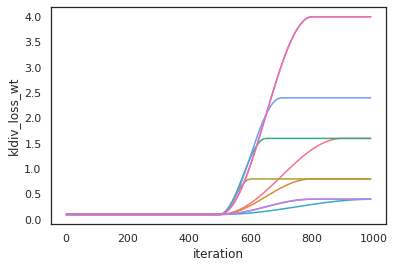

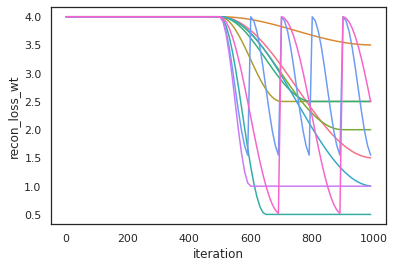

In [4]:
import liGAN
import random, torch

sns.set_palette('husl', 10)

def plot_ls(ylabel, start_wt, type, period, end_wt):
    f, _ = liGAN.loss_fns.get_loss_schedule(
        start_wt=start_wt,
        end_wt=end_wt,
        start_iter=500,
        period=period,
        type=type
    )
    x = torch.arange(1, 1000, 10)
    y = [f(x_) for x_ in x]
    plt.plot(x, y)
    plt.ylabel(ylabel)
    plt.xlabel('iteration')

plt.figure()
for i in range(10):
    plot_ls(
        'kldiv_loss_wt', 0.1,
        random.choice('ddcr'),
        random.choice([100, 150, 200, 250, 300, 400, 500]),
        random.choice([0.2, 0.4, 0.8, 1.6, 2.4, 3.2, 4.0])
    )
plt.figure()
for i in range(10):
    plot_ls(
        'recon_loss_wt', 4.0,
        random.choice('ddcr'),
        random.choice([100, 150, 200, 250, 300, 400, 500]),
        random.choice([3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5])
    )

In [5]:
import param_search

base_params = param_search.ParamSpace( # train6 - prior improvement
    
    # data params
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    batch_size=8,
    
    # typer params
    typer_fns='oadc',
    use_rec_elems=True,
    radius_fn=1.0,
    
    # gen model params
    gen_n_filters=28,
    gen_init_conv_pool=0,
    gen_n_levels=4,
    gen_conv_per_level=4,
    gen_spectral_norm=1,
    n_latent=128,
    skip_connect=True,
    block_type='r',
    growth_rate=0,
    width_factor=2,
    bn_factor=0,
    
    # loss fn params
    kldiv_loss_start_wt=0.1,
    recon_loss_start_wt=4.0,
    steric_loss_start_wt=1.0,
    gan_loss_start_wt=0.0,

    # optimizer params
    optim_type=['RMSprop'],
    gen_lr=1e-5,
    gen_grad_clip=5000,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    learn_recon_var=[0, 1],
    
    # other stuff
    group_name='6',
    gen_k_iter=600,
    sbatch_line='#SBATCH -C M12',
    
    # no GAN disc
    disc_n_filters=0,
    disc_init_conv_pool=0,
    disc_n_levels=0,
    disc_conv_per_level=0,
    n_disc_train_iters=0,
    disc_lr=0.0,

    # stage2 VAE params
    model_type='CVAE2',
    prior_n_layers=[0,1,2],
    random_seed=range(100),
    kldiv2_loss_start_wt=[0.5, 1.0, 2.0, 4.0],
    recon2_loss_start_wt=[0.5, 1.0, 2.0, 4.0],
)

sched0_params = param_search.ParamSpace( # no loss wt schedule
    start_iter=450000,
    kldiv_loss_end_wt=0.1,
    kldiv_loss_period=0,
    kldiv_loss_sched_type='n',
    recon_loss_end_wt=4.0,
    recon_loss_period=0,
    recon_loss_sched_type='n'
)
sched1_params = param_search.ParamSpace( # increase kl div loss wt
    start_iter=450000,
    kldiv_loss_end_wt=[0.2, 0.4, 0.8, 1.6, 2.4, 3.2, 4.0],
    kldiv_loss_period=[100, 150, 200, 250, 300, 400, 500],
    kldiv_loss_sched_type=['d', 'd', 'c', 'r'],
    recon_loss_end_wt=4.0,
    recon_loss_period=0,
    recon_loss_sched_type='n'
)
sched2_params = param_search.ParamSpace( # decrease recon loss wt
    start_iter=450000,
    kldiv_loss_end_wt=0.1,
    kldiv_loss_period=0,
    kldiv_loss_sched_type='n',
    recon_loss_end_wt=[3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5],
    recon_loss_period=[100, 150, 200, 250, 300, 400, 500],
    recon_loss_sched_type=['d', 'd', 'c', 'r']
)

# evenly sample each subspace
train_params = base_params * (
    len(sched1_params)*len(sched2_params)*sched0_params + 
    len(sched0_params)*len(sched2_params)*sched1_params +
    len(sched0_params)*len(sched1_params)*sched2_params
)

name_format = 'train{group_name}_{model_type}_{learn_recon_var}_' \
    'p{prior_n_layers}_{kldiv2_loss_start_wt}_{recon2_loss_start_wt}_' \
    'k{kldiv_loss_period}_{kldiv_loss_sched_type}_{kldiv_loss_end_wt}_' \
    'r{recon_loss_period}_{recon_loss_sched_type}_{recon_loss_end_wt}_' \
    '{random_seed}'

len(train_params)

1106380800

In [715]:
import random
random.seed(0)
np.random.seed(0)

sampled_params = train_params.sample(100, replace=False)

for p in sampled_params:
    name = name_format.format(**p)
    print(name)

print(len(sampled_params))

train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8
train6_CVAE2_1_p0_2.0_0.5_k0_n_0.1_r100_d_0.5_2
train6_CVAE2_1_p1_4.0_1.0_k0_n_0.1_r300_c_2.5_93
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r0_n_4.0_89
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26
train6_CVAE2_0_p1_0.5_4.0_k0_n_0.1_r0_n_4.0_43
train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r250_c_1.5_46
train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r0_n_4.0_49
train6_CVAE2_0_p0_4.0_2.0_k500_d_4.0_r0_n_4.0_78
train6_CVAE2_0_p0_0.5_0.5_k0_n_0.1_r0_n_4.0_45
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47
train6_CVAE2_1_p2_0.5_4.0_k0_n_0.1_r150_c_3.5_81
train6_CVAE2_1_p2_1.0_0.5_k500_c_3.2_r0_n_4.0_66
train6_CVAE2_1_p2_2.0_1.0_k250_r_0.2_r0_n_4.0_89
train6_CVAE2_0_p2_4.0_2.0_k0_n_0.1_r100_d_3.5_58
train6_CVAE2_0_p1_0.5_0.5_k250_r_4.0_r0_n_4.0_70
train6_CVAE2_1_p2_0.5_4.0_k0_n_0.1_r300_c_1.0_84
train6_CVAE2_0_p1_1.0_1.0_k0_n_0.1_r0_n_4.0_1
train6_CVAE2_0_p1_1.0_2.0_k0_n_0.1_r300_r_2.5_39
train6_CVAE2_1_p1_4.0_0.5_k500_c_0.2_r0_n_4.0_63
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.

In [716]:
for template_file in [
    'gen_poster.config', 'gen_poster.sh',
    'gen_prior.config', 'gen_prior.sh',
    'gen_poster2.config', 'gen_poster2.sh',
    'gen_prior2.config', 'gen_prior2.sh',
    'train.config', 'train.sh'
]:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=sampled_params,
    )

train_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p0_2.0_0.5_k0_n_0.1_r100_d_0.5_2/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p1_4.0_1.0_k0_n_0.1_r300_c_2.5_93/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r0_n_4.0_89/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_0.5_4.0_k0_n_0.1_r0_n_4.0_43/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r250_c_1.5_46/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r0_n_4.0_49/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/traini

In [358]:
job_ids = param_search.submit(train_job_files)

In [6]:
train_jobs = pd.DataFrame(dict(
    job_id=[
        # these first jobs were full-scale, had major performance issues, didn't have separate receptor element ranges
        #[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],

        # train0 CVAEs, CVAEGANs, and CGANs, first submit
        [6818214, 6818215, 6818216, 6818217, 6818218, 6818219, 6818220, 6818221, 6818222, 6818223, 6818224, 6818225, 6818226, 6818227, 6818228, 6818229, 6818230, 6818231, 6818232, 6818233, 6818234, 6818235, 6818236, 6818237, 6818238, 6818239, 6818240, 6818241, 6818242, 6818243],

        # train1 CVAEs, CVAEGANs, and CGANs, first submit (held most CVAEGANs and CGANs to allow full data jobs)
        [6820019, 6820020, 6820021, 6820022, 6820023, 6820024, 6820025, 6820026, 6820027, 6820028, 6820029, 6820030, 6820031, 6820032, 6820033, 6820034, 6820035, 6820036, 6820037, 6820038, 6820039, 6820040, 6820041, 6820042, 6820043, 6820044, 6820045, 6820046, 6820047, 6820048, 6820049, 6820050, 6820051, 6820052, 6820053, 6820054, 6820055, 6820056, 6820057, 6820058, 6820059, 6820060, 6820061, 6820062, 6820063, 6820064, 6820065, 6820066, 6820067, 6820068, 6820069, 6820070, 6820071, 6820072, 6820073, 6820074, 6820075, 6820076, 6820077, 6820078, 6820079, 6820080, 6820081, 6820082, 6820083, 6820084, 6820085, 6820086, 6820087, 6820088, 6820089, 6820090, 6820091, 6820092, 6820093, 6820094, 6820095, 6820096, 6820097, 6820098, 6820099, 6820100, 6820101, 6820102, 6820103, 6820104, 6820105, 6820106, 6820107, 6820108],

        # train1 models that got CUDA error on g005, resubmit with -x g005
        [6820859, 6820860, 6820861, 6820862, 6820863, 6820864, 6820865, 6820866, 6820867, 6820868, 6820869, 6820870, 6820871, 6820872, 6820873, 6820874, 6820875, 6820876, 6820877, 6820878, 6820879, 6820880, 6820881, 6820882, 6820883, 6820884, 6820885, 6820886, 6820887, 6820888, 6820889, 6820890, 6820891, 6820892, 6820893, 6820894, 6820895, 6820896, 6820897, 6820898, 6820899, 6820900, 6820901, 6820902, 6820903, 6820904, 6820905, 6820906, 6820907, 6820908, 6820909, 6820910, 6820911, 6820912, 6820913, 6820914, 6820915, 6820916, 6820917, 6820918, 6820919, 6820920, 6820921, 6820922, 6820923, 6820924, 6820925, 6820926, 6820927, 6820928],

        # train2 CVAEs on full dataset, first submit
        [6820935, 6820936, 6820937, 6820938, 6820939, 6820940, 6820941, 6820942, 6820943, 6820944, 6820945, 6820946, 6820947, 6820948, 6820949, 6820950, 6820951, 6820952, 6820953, 6820954, 6820955, 6820956, 6820957, 6820958],

        # train1 CVAEs with gen_lr=1e-5 that hit 100k, resubmit to train to 200k- errors loading state
        #[6831137, 6831138, 6831139, 6831140, 6831141, 6831142, 6831143],
        
        # train1- same jobs as last submit, but fixed loading solver state
        [6834544, 6834545, 6834546, 6834547, 6834548, 6834549],

        # BUG STARTS HERE- switched from lig elems to rec elems (for rec AND lig)
        # train2- resubmit all jobs, training to 200k- these did not have continue set, so they started from 0
        #[6837351, 6837352, 6837353, 6837354, 6837355, 6837356, 6837357, 6837358, 6837359, 6837360, 6837361, 6837362, 6837363, 6837364, 6837365, 6837366, 6837367, 6837368, 6837369, 6837370, 6837371, 6837372, 6837373, 6837374],

        # train2- let's try that again
        [6837376, 6837377, 6837378, 6837379, 6837380, 6837381, 6837382, 6837383, 6837384, 6837385, 6837386, 6837387, 6837388, 6837389, 6837390, 6837391, 6837392, 6837393, 6837394, 6837395, 6837396, 6837397, 6837398, 6837399],

        # train1- released jobs tried to continue from iter 0, but no metrics file was found. add try-except to ignore this
        [6837497, 6837498, 6837499, 6837500, 6837501, 6837502, 6837503, 6837504, 6837505, 6837506, 6837507, 6837508, 6837509, 6837510, 6837511, 6837512, 6837513, 6837514, 6837515, 6837516, 6837517, 6837518, 6837519, 6837520, 6837521, 6837522, 6837523, 6837524, 6837525, 6837526, 6837527, 6837528, 6837529, 6837530, 6837531, 6837532, 6837533, 6837534, 6837535, 6837536, 6837537, 6837538, 6837539, 6837540, 6837541, 6837542, 6837543, 6837544, 6837545, 6837546, 6837547, 6837548],

        # train2- train full data CVAEs to 300k
        [6837556, 6837557, 6837558, 6837559, 6837560, 6837561, 6837562, 6837563, 6837564, 6837565, 6837566, 6837567, 6837568, 6837569, 6837570, 6837571, 6837572, 6837573, 6837574, 6837575, 6837576, 6837577, 6837578, 6837579],

        # train2- manually resubmitted with fixed SBATCH -c M16 due to cuda oom (expecting more...)
        [6837581, 6837582],
        
        # train1- resubmit best lrs combos of each model (CVAEs to 300k, others to 200k)
        [6845980, 6845981, 6845982, 6845983, 6845984, 6845985, 6845986, 6845987, 6845988, 6845989, 6845990, 6845991, 6845992, 6845993, 6845994, 6845995, 6845996, 6845997],

        # train2- manually resubmitted job, got unable to allocate bytes on torch.save
        [6845999],
        
        # BUG FIXED HERE- switched to rec elems for rec, lig elems for lig
        # train1- resubmit best of each model type to train out the bug
        [6853415, 6853416, 6853417, 6853418, 6853419, 6853420, 6853421, 6853422, 6853423, 6853424, 6853425, 6853426, 6853427, 6853428, 6853429, 6853430, 6853431, 6853432],
        # train2- resubmit best lr combo models to train out the bug
        [6853433, 6853434, 6853435, 6853436, 6853437, 6853438, 6853439, 6853440],
        
        # train3- random search space seed 0 (held)
        [6879506, 6879509, 6879511, 6879513, 6879514, 6879515, 6879516, 6879517, 6879518, 6879519, 6879520, 6879521, 6879522, 6879523, 6879524, 6879525, 6879526, 6879527, 6879528, 6879529, 6879530, 6879531, 6879532, 6879533, 6879534, 6879535, 6879536, 6879537, 6879538, 6879539, 6879541, 6879542, 6879544, 6879546, 6879551, 6879553, 6879555, 6879560, 6879561, 6879564, 6879567, 6879569, 6879571, 6879572, 6879573, 6879575, 6879576, 6879577, 6879578, 6879579, 6879580, 6879581, 6879582, 6879583, 6879584, 6879585, 6879586, 6879587, 6879588, 6879589, 6879590, 6879591, 6879592, 6879593, 6879594, 6879595, 6879596, 6879599, 6879602, 6879603, 6879605, 6879608, 6879613, 6879617, 6879619, 6879622, 6879624, 6879626, 6879627, 6879628, 6879629, 6879631, 6879632, 6879633, 6879634, 6879635, 6879636, 6879637, 6879638, 6879639, 6879640, 6879641, 6879642, 6879643, 6879644, 6879645, 6879646, 6879647, 6879648, 6879649, 6879650, 6879651, 6879652, 6879653, 6879654, 6879655, 6879656, 6879665, 6879666, 6879667, 6879668, 6879669, 6879670, 6879671, 6879672, 6879673, 6879674, 6879675, 6879676, 6879677, 6879678, 6879679, 6879680, 6879681, 6879682, 6879683, 6879684, 6879685, 6879686, 6879687, 6879688, 6879689, 6879702, 6879703, 6879704, 6879705, 6879706, 6879707, 6879708, 6879709, 6879710, 6879711, 6879712, 6879713, 6879714, 6879715, 6879716, 6879717, 6879718, 6879719, 6879720, 6879721, 6879722, 6879723, 6879724, 6879725, 6879752, 6879753, 6879754, 6879755, 6879756, 6879757, 6879758, 6879759, 6879760, 6879761, 6879762, 6879763, 6879764, 6879765, 6879766, 6879767, 6879768, 6879769, 6879770, 6879771, 6879772, 6879783, 6879784, 6879785, 6879786, 6879787, 6879788, 6879789, 6879790, 6879791, 6879792, 6879793, 6879794, 6879795, 6879796, 6879797, 6879798, 6879799, 6879800, 6879801, 6879802, 6879803, 6879804, 6879805, 6879806, 6879807, 6879820, 6879821, 6879822, 6879823, 6879824, 6879825, 6879826, 6879827, 6879828, 6879829, 6879830, 6879831, 6879832, 6879833, 6879834, 6879835, 6879836, 6879837, 6879838, 6879839, 6879840, 6879841, 6879842, 6879843, 6879844, 6879865, 6879866, 6879867, 6879868, 6879869, 6879870, 6879871, 6879872, 6879873, 6879874, 6879875, 6879876, 6879877, 6879878, 6879879, 6879880, 6879881, 6879882, 6879883, 6879884, 6879885, 6879886, 6879887, 6879888, 6879897, 6879898, 6879899, 6879900, 6879901, 6879902, 6879903, 6879904, 6879905, 6879906, 6879907, 6879908, 6879909, 6879910, 6879911, 6879912, 6879913, 6879914, 6879915, 6879916, 6879917, 6879918, 6879919, 6879920, 6879921, 6879939, 6879940, 6879941, 6879942, 6879943, 6879944, 6879945, 6879946, 6879947, 6879948, 6879949, 6879950, 6879951, 6879952, 6879953, 6879954, 6879955, 6879956, 6879957, 6879958, 6879959, 6879960, 6879984, 6879985],

        # train3- fix unbound loss_gen error and resubmit (jobs with disc_train_iters=1) (released)
        [6883168, 6883169, 6883170, 6883171, 6883172, 6883173, 6883174, 6883175, 6883176, 6883177, 6883178, 6883179],
        
        # train3- resubmit CUDA oom models with -C M12 (released)
        [6883206, 6883207, 6883208, 6883209],
        
        # train3- jobs that already reached < 150 test recon loss by 100k
        [6889371, 6889372, 6889373, 6889374, 6889375, 6889376, 6889377],
        
        # train3- resubmitted jobs with under < 200 test recon loss (same models as prev to 300k plus some new to 200k)
        [6890657, 6890658, 6890659, 6890660, 6890661, 6890662, 6890663, 6890664, 6890665, 6890666, 6890667, 6890668, 6890669, 6890670, 6890671, 6890672],

        # train3- resubmit CUDA oom models with -C M16, then cancel ones already running (reason=dependency)
        [6890882, 6890883, 6890884, 6890885, 6890886, 6890887, 6890888, 6890889, 6890890, 6890891, 6890892, 6890893, 6890894, 6890895, 6890896, 6890897, 6890898, 6890899, 6890900, 6890901, 6890902, 6890903, 6890904, 6890905, 6890906],

        # train4 - submit all with clamped steric loss
        [6922074, 6922075, 6922076, 6922077, 6922078, 6922079, 6922080, 6922081, 6922082, 6922083, 6922084, 6922085, 6922086, 6922087, 6922088, 6922089, 6922090, 6922091, 6922092, 6922093, 6922094, 6922095, 6922096, 6922097, 6922098, 6922099, 6922100, 6922101, 6922102, 6922103, 6922104, 6922105, 6922106, 6922107, 6922108, 6922109, 6922110, 6922111, 6922112, 6922113, 6922114, 6922115, 6922116, 6922117, 6922118, 6922119, 6922120, 6922121, 6922122, 6922123, 6922124, 6922125, 6922126, 6922127, 6922128, 6922129, 6922130, 6922131, 6922132, 6922133, 6922134, 6922135, 6922136, 6922137, 6922138, 6922139, 6922140, 6922141, 6922142, 6922143, 6922144, 6922145, 6922146, 6922147, 6922148, 6922149, 6922150, 6922151, 6922152, 6922153, 6922154, 6922155, 6922156, 6922157, 6922158, 6922159, 6922160, 6922161, 6922162, 6922163, 6922164, 6922165, 6922166, 6922167, 6922168, 6922169, 6922170, 6922171, 6922172, 6922173],

        # train4- resubmit better-than-train3 jobs that errored out
        [6970651, 6970652, 6970653, 6970654, 6970655, 6970656, 6970657, 6970658, 6970659, 6970660],
        
        # train4- resubmit all cuda oom jobs with more requested GPU memory
        [6970667, 6970668, 6970669, 6970670, 6970671, 6970672, 6970673, 6970674, 6970675, 6970676, 6970677, 6970678, 6970679, 6970680, 6970681, 6970682, 6970683, 6970684, 6970685],

        # train5 - submit all in order of decreasing estimated GPU memory
        [6971032, 6971033, 6971034, 6971035, 6971036, 6971037, 6971038, 6971039, 6971040, 6971041, 6971042, 6971043, 6971044, 6971045, 6971046, 6971047, 6971048, 6971049, 6971050, 6971051, 6971052, 6971053, 6971054, 6971055, 6971056, 6971057, 6971058, 6971059, 6971060, 6971061, 6971062, 6971063, 6971064, 6971065, 6971066, 6971067, 6971068, 6971069, 6971070, 6971071, 6971072, 6971073, 6971074, 6971075, 6971076, 6971077, 6971078, 6971079, 6971080, 6971081, 6971082, 6971083, 6971084, 6971085, 6971086, 6971087, 6971088, 6971089, 6971090, 6971091, 6971092, 6971093, 6971094, 6971095, 6971096, 6971097, 6971098, 6971099, 6971100, 6971101, 6971102, 6971103, 6971104, 6971105, 6971106, 6971107, 6971108, 6971109, 6971110, 6971111, 6971112, 6971113, 6971114, 6971115, 6971116, 6971117, 6971118, 6971119, 6971120, 6971121, 6971122, 6971123, 6971124, 6971125, 6971126, 6971127, 6971128, 6971129, 6971130, 6971131],

        # train5 - resubmit OOM jobs with batch size = 4 and no SBATCH line
        [6971166, 6971167, 6971168, 6971169, 6971170, 6971171, 6971172, 6971173, 6971174, 6971175, 6971176, 6971177, 6971178, 6971179, 6971180, 6971181, 6971182, 6971183, 6971184, 6971185, 6971186, 6971187, 6971188, 6971189, 6971190, 6971191, 6971192, 6971193, 6971194, 6971195, 6971196, 6971197, 6971198, 6971199],

        # train4 and train5 - resubmit promising jobs that are not currently running
        [6971523, 6971524, 6971525, 6971526, 6971527, 6971528, 6971529, 6971530, 6971531, 6971532, 6971533, 6971534],
        [6971535, 6971536, 6971537, 6971538, 6971539, 6971540, 6971541, 6971542, 6971543, 6971544, 6971545, 6971546, 6971547, 6971548, 6971549, 6971550, 6971551, 6971552, 6971553, 6971554, 6971555, 6971556, 6971557, 6971558, 6971559, 6971560, 6971561, 6971562, 6971563, 6971564, 6971565, 6971566],
        
        # train6- first submit with no mem request, few gpus available, most failed with cuda oom
        [6987997, 6987998, 6987999, 6988000, 6988001, 6988002, 6988003, 6988004, 6988005, 6988006, 6988007, 6988008, 6988009, 6988010, 6988011, 6988012, 6988013, 6988014, 6988015, 6988016, 6988017, 6988018, 6988019, 6988020, 6988021, 6988022, 6988023, 6988024, 6988025, 6988026, 6988027, 6988028, 6988029, 6988030, 6988031, 6988032, 6988033, 6988034, 6988035, 6988036, 6988037, 6988038, 6988039, 6988040, 6988041, 6988042, 6988043, 6988044, 6988045, 6988046, 6988047, 6988048, 6988049, 6988050, 6988051, 6988052, 6988053, 6988054, 6988055, 6988056, 6988057, 6988058, 6988059, 6988060, 6988061, 6988062, 6988063, 6988064, 6988065, 6988066, 6988067, 6988068, 6988069, 6988070, 6988071, 6988072, 6988073, 6988074, 6988075, 6988076, 6988077, 6988078, 6988079, 6988080, 6988081, 6988082, 6988083, 6988084, 6988085, 6988086, 6988087, 6988088, 6988089, 6988090, 6988091, 6988092, 6988093, 6988094, 6988095, 6988096],
        
        # train6- resubmit with M12 and fix solver state files after name format change
        [6988124, 6988125, 6988126, 6988127, 6988128, 6988129, 6988130, 6988131, 6988132, 6988133, 6988134, 6988135, 6988136, 6988137, 6988138, 6988139, 6988140, 6988141, 6988142, 6988143, 6988144, 6988145, 6988146, 6988147, 6988148, 6988149, 6988150, 6988151, 6988152, 6988153, 6988154, 6988155, 6988156, 6988157, 6988158, 6988159, 6988160, 6988161, 6988162, 6988163, 6988164, 6988165, 6988166, 6988167, 6988168, 6988169, 6988170, 6988171, 6988172, 6988173, 6988174, 6988175, 6988176, 6988177, 6988178, 6988179, 6988180, 6988181, 6988182, 6988183, 6988184, 6988185, 6988186, 6988187, 6988188, 6988189, 6988190, 6988191, 6988192, 6988193, 6988194, 6988195, 6988196, 6988197, 6988198, 6988199, 6988200, 6988201, 6988202, 6988203, 6988204, 6988205, 6988206, 6988207, 6988208, 6988209, 6988210, 6988211, 6988212, 6988213, 6988214, 6988215, 6988216, 6988217, 6988218, 6988219, 6988220, 6988221, 6988222, 6988223],

        # train6- cancel and resubmit me with revised vae2 loss weights
        [6988235, 6988236, 6988237, 6988238, 6988239, 6988240, 6988241, 6988242, 6988243, 6988244, 6988245, 6988246, 6988247, 6988248, 6988249, 6988250, 6988251, 6988252, 6988253, 6988254, 6988255, 6988256, 6988257, 6988258, 6988259, 6988260, 6988261, 6988262, 6988263, 6988264, 6988265, 6988266, 6988267, 6988268, 6988269, 6988270, 6988271, 6988272, 6988273, 6988274, 6988275, 6988276, 6988277, 6988278, 6988279, 6988280, 6988281, 6988282, 6988283, 6988284, 6988285, 6988286, 6988287, 6988288, 6988289, 6988290, 6988291, 6988292, 6988293, 6988294, 6988295, 6988296, 6988297, 6988298, 6988299, 6988300, 6988301, 6988302, 6988303, 6988304, 6988305, 6988306, 6988307, 6988308, 6988309, 6988310, 6988311, 6988312, 6988313, 6988314, 6988315, 6988316, 6988317, 6988318, 6988319, 6988320, 6988321, 6988322, 6988323, 6988324, 6988325, 6988326, 6988327, 6988328, 6988329, 6988330, 6988331, 6988332, 6988333, 6988334],
        
        # train6- accidentally cancelled all jobs, resumbit ones with increased prior n_atoms
        [7017136, 7017139, 7017141, 7017142, 7017146, 7017147, 7017148, 7017149, 7017150, 7017151, 7017152, 7017153, 7017154, 7017155, 7017156, 7017157, 7017158, 7017159, 7017160, 7017161, 6988316, 6988317, 6988318, 6988319, 6988320, 6988321, 6988322, 6988323, 6988324, 6988325, 6988326, 6988327, 6988328, 6988329, 6988330, 6988331, 6988332, 6988333, 6988334, 7017120, 7017121, 7017122, 7017123, 7017124, 7017125, 7017126, 7017127, 7017128, 7017129, 7017130, 7017131, 7017133]
    ],
    group_name=[0,1,1,2,1,2,1,2,2,1,2,1,2,3,3,3,3,3,3,4,4,4,5,5,4,5,6,6,6,6]
)).explode('job_id')

train_jobs = train_jobs[train_jobs['group_name'].isin({4,6})]

In [7]:
%%time
import param_search
param_search.job_queues.verbose = False
from collections import defaultdict

print('Getting queue status')
qstat = param_search.status(job=train_jobs['job_id'])

if qstat['job_id'].dtype in {str, object}:
    qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

print('Merging data frames')
train_jobs = train_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
train_jobs['work_dir'] = train_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
train_jobs['job_name'] = train_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_jobs['job_file'] = train_jobs.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_jobs['stdout_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_jobs['stderr_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
train_jobs['metrics_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_name}.train_metrics'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 666 ms, sys: 886 ms, total: 1.55 s
Wall time: 1min 7s


In [8]:
%%time

print('Reading stdout files (train)')
train_jobs['stdout_train'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(test.*?|train model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stdout files (test)')
train_jobs['stdout_test'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(train.*?|test model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stderr files')
train_jobs['stderr'] = train_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    ignore_pat=None,
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
train_jobs['job_state'] = train_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(train_jobs['job_name'].unique())}
train_jobs['job_name_idx'] = train_jobs['job_name'].map(job_name_idx)

Reading stdout files (train)
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Reading stdout files (test)
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_colwidth', 100)
import re
import datetime as dt

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0]) if len(x) == 3 else 0
    minutes = int(x[-2]) if len(x) >= 2 else 0
    seconds = int(x[-1])
    return days + (hours + (minutes + seconds/60)/60)/24

train_jobs['iteration'] = train_jobs['stdout_train'].map(
    lambda x: int(re.search('iteration=(\d+) ', x).group(1)) if x else np.nan
)
train_jobs['train_recon_loss'] = train_jobs['stdout_train'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_recon_loss'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_type_diff'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('lig_gen_fit_type_diff=(\S+) ', x).group(1))) if x and 'type_diff' in x else np.nan
)

train_jobs['days'] = train_jobs['runtime'].map(as_timedelta)
train_jobs['iters_day'] = ((train_jobs['iteration'] - 450000) / train_jobs['days']).map(np.round)

running_jobs = train_jobs[
    (train_jobs['job_state'] == 'R')
]

running_jobs.set_index(['group_name', 'job_name', 'job_id']) \
    .sort_values(['job_name_idx', 'job_id'])[[
    'runtime', 'node_id', 'job_state',
    'iteration', 'days', 'iters_day',
    'train_recon_loss', 'test_recon_loss', 'test_type_diff',
    #'stdout_train', 'stdout_test',
    'stderr',
]]

runtime node_id job_state  iteration      days  iters_day  train_recon_loss  test_recon_loss  test_type_diff stderr
group_name job_name                                         job_id                                                                                                                         
6          train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8  7017129  3-12:51:44    g016         R   837199.0  3.535926   109504.0               NaN              NaN             NaN   None
           train6_CVAE2_0_p1_1.0_0.5_k0_n_0.1_r250_c_1.5_46 7017120  3-12:55:23    g017         R   784492.0  3.538461    94530.0              31.0              NaN             NaN   None
           train6_CVAE2_0_p0_4.0_2.0_k500_d_4.0_r0_n_4.0_78 7017121  3-12:55:23    g017         R   782253.0  3.538461    93898.0               NaN              NaN             NaN   None
           train6_CVAE2_0_p2_2.0_4.0_k0_n_0.1_r0_n_4.0_11   7017122  3-12:55:23    g017         R   841228.0  3.538461   110564.0              22.0              NaN             NaN   None
           train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65 7017136  3-07:39:12    g014         R   838984.0  3.318889   117203.0              64.0              NaN             NaN   None
           train6_CVAE2_1_p1_1.0_2.0_k0_n_0.1_r150_d_2.5_35 7017123  3-12:55:23    g017         R   864951.0  3.538461   117269.0               NaN              NaN             NaN   None
           train6_CVAE2_0_p1_0.5_2.0_k0_n_0.1_r100_c_1.0_48 7017124  3-12:55:23    g014         R   812256.0  3.538461   102377.0              34.0              NaN             NaN   None
           train6_CVAE2_1_p1_1.0_4.0_k0_n_0.1_r0_n_4.0_19   7017125  3-12:55:23    g015         R   794910.0  3.538461    97475.0        -4831909.0              NaN             NaN   None
           train6_CVAE2_1_p1_4.0_1.0_k0_n_0.1_r0_n_4.0_65   7017142    23:35:13    g014         R   686842.0  0.982789   240990.0        -3323861.0              NaN             NaN   None
           train6_CVAE2_0_p0_2.0_1.0_k150_c_2.4_r0_n_4.0_59 7017126  3-12:55:23    g016         R   826399.0  3.538461   106374.0               NaN              NaN             NaN   None
           train6_CVAE2_0_p1_1.0_1.0_k150_c_3.2_r0_n_4.0_94 7017127  3-12:55:23    g016         R   804899.0  3.538461   100298.0               NaN              NaN             NaN   None
           train6_CVAE2_0_p0_2.0_1.0_k300_r_0.8_r0_n_4.0_19 7017128  3-12:55:21    g016         R   804999.0  3.538438   100326.0               NaN              NaN             NaN   None
           train6_CVAE2_1_p1_1.0_4.0_k0_n_0.1_r100_c_0.5_56 7017146    23:35:13    g015         R   630385.0  0.982789   183544.0               NaN              NaN             NaN   None
           train6_CVAE2_1_p1_1.0_0.5_k0_n_0.1_r0_n_4.0_81   7017147    23:35:13    g015         R   650099.0  0.982789   203603.0               NaN              NaN             NaN   None
           train6_CVAE2_1_p2_1.0_1.0_k0_n_0.1_r0_n_4.0_23   7017148    23:35:13    g018         R   662290.0  0.982789   216008.0        -2979720.0              NaN             NaN   None
           train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r150_d_0.5_29 7017149    23:35:13    g018         R   669187.0  0.982789   223025.0               NaN              NaN             NaN   None
           train6_CVAE2_1_p1_1.0_0.5_k0_n_0.1_r300_c_1.0_39 7017150    23:35:13    g018         R   654459.0  0.982789   208039.0               NaN              NaN             NaN   None
           train6_CVAE2_0_p0_1.0_2.0_k0_n_0.1_r0_n_4.0_7    7017151    23:35:13    g018         R   621745.0  0.982789   174753.0               NaN              NaN             NaN   None
           train6_CVAE2_0_p0_2.0_2.0_k0_n_0.1_r0_n_4.0_77   6988319  3-13:07:33    g002         R   682054.0  3.546910    65424.0              12.0              NaN             NaN   None
                                                            6988319  3-13:07:33    g002         R   682054.0  3.546910    65

In [13]:
best_train3_job = 'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_22'

train4_jobs = train_jobs[
    (train_jobs['job_name'] == best_train3_job) | (train_jobs['group_name'] == 4)
]
train4_jobs.groupby('group_name')['job_name'].nunique()

group_name
4    100
Name: job_name, dtype: int64

In [14]:
best_train4_job = 'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45'

train5_jobs = train_jobs[
    (train_jobs['job_name'] == best_train4_job) | (train_jobs['group_name'] == 5)
]
train5_jobs.groupby('group_name')['job_name'].nunique()

group_name
4    1
Name: job_name, dtype: int64

In [15]:
%%time
# read in training metrics

import param_search
try:
    del train_metrics # this is very big (>12gb), delete it before we reload it
    del last_iter_df
except NameError:
    pass

metric_jobs = train_jobs[
    (train_jobs['job_name'] == best_train3_job) |
    (train_jobs['job_name'] == best_train4_job) |
    (train_jobs['job_name'] == 'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65') |
    (train_jobs['job_name'] == 'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8')
]

dfs = []
for job_file, metrics_file in zip(metric_jobs['job_file'], metric_jobs['metrics_file']):
    try:
        df = pd.read_csv(metrics_file, sep=' ')
        print(metrics_file)
        #print('.', end='')
    except Exception as e:
        print(metrics_file, e, file=sys.stderr)
        continue
    params = param_search.params.read_params(job_file, line_start='# ')
    for param, value in params.items():
        assert param not in df, param + ' is both a param and a metric ' + metrics_file
        df[param] = value
        
    dfs.append(df)

train_metrics = pd.concat(dfs)
del dfs
train_metrics.groupby(['group_name', 'job_name'])[['iteration']].max()

train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45.train_metrics
train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45.train_metrics
train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45.train_metrics
train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8.train_metrics
train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65/train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65.train_metrics
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65/train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65.train_metrics
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8.train_metrics
CPU times: user 

iteration
group_name job_name                                                                  
4          train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45     592600
6          train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65                    839100
           train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8                     837300

In [31]:
def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue, sort=False):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    

iter_bin_size = 5000
train_metrics['iter_bin'] = (train_metrics['iteration'] // iter_bin_size) * iter_bin_size

#train_metrics.reset_index(inplace=True)
plot_df = train_metrics.copy()

plot_df['epoch'] = plot_df['iter_bin'] * plot_df['batch_size'] / 220636

if 'gan_loss' not in plot_df:
    plot_df['gan_loss'] = np.nan
    
plot_df['log_abs_loss'] = np.log10(plot_df['loss'].abs())
plot_df['log_kldiv_loss'] = np.log10(plot_df['kldiv_loss'])
plot_df['log_abs_recon_loss'] = np.log10(plot_df['recon_loss'].abs())
plot_df['log_steric_loss'] = np.log10(plot_df['steric_loss'])
plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())
plot_df['log_kldiv2_loss'] = np.log10(plot_df['kldiv2_loss'])
plot_df['log_abs_recon2_loss'] = np.log10(plot_df['recon2_loss'].abs())

# apply Bessel's correction to sample variances
plot_df['bessels_correction'] = plot_df['batch_size'] / (plot_df['batch_size'] - 1)
plot_df['lig_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_fit_n_atoms_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_fit_type_variance'] *= plot_df['bessels_correction']

# get recon variance
plot_df['recon_variance'] = np.exp(plot_df['recon_log_var'])
plot_df['recon2_variance'] = np.exp(plot_df['recon2_log_var'])

# transform recon loss to account for variance
#plot_df['recon_loss'] = (
#    plot_df['recon_loss'] - (18*48**3)*plot_df['recon_log_var']
#) * plot_df['recon_variance']**2

plot_df['recon2_loss'] = (
    plot_df['recon2_loss'] - (128)*plot_df['recon2_log_var']
) * plot_df['recon2_variance']**2

train_y = [
    'loss',
    'kldiv_loss',
    'recon_loss',
    'kldiv2_loss',
    'recon2_loss',
    
    'log_abs_loss',
    'log_kldiv_loss',
    'log_abs_recon_loss',
    'log_kldiv2_loss',
    'log_abs_recon2_loss',
    
    'gen_grad_norm',
    'kldiv_loss_wt',
    'recon_loss_wt',
    'recon_variance',
    'recon2_variance',
    
    'lig_norm',
    'lig_gen_norm',
    'lig_variance',
    'lig_gen_variance',
    'lig_gen_L2_loss',

    'lig_n_atoms',
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_n_atoms_variance',
    'lig_gen_fit_elem_diff',
    'lig_gen_fit_elem_variance',
]
train_x = 'iter_bin'

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [132]:
colors = get_palette(
    n_hues=2,
    n_shades=3,
    min_val=0.1
)
#colors = colors[]
sns.set_palette(colors)
colors

[(0.23357750661563065, 0.35906460602221413, 0.5923102790472873),
 (0.3340547629416667, 0.5076725819763576, 0.8262086967916293),
 (0.6313402380915445, 0.7209075753992373, 0.8867126249121258),
 (0.6685872864204695, 0.3909025381651925, 0.23698375630364088),
 (0.9346729947303557, 0.5545300321324377, 0.3411123461431624),
 (0.9423760477632344, 0.7440581090508169, 0.6338808854859537)]

In [133]:
best_train4_job

'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45'

CPU times: user 23.1 s, sys: 3.77 s, total: 26.9 s
Wall time: 26.9 s


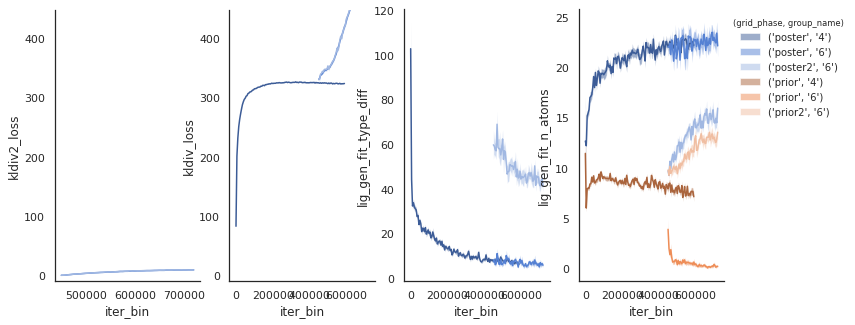

In [136]:
%%time

# plot running train 6 jobs
hue = ['grid_phase', 'group_name'] #['grid_phase', 'job_name']

fig = param_search.plot(
    plot_df[
        (
            (
                (plot_df['job_name'] == best_train4_job) |
                (plot_df['job_name'] == 'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8')
            )# &
            #plot_df['grid_phase'].isin({'poster', 'prior'})
        ) &
        #(plot_df['iteration'] > 400000) &
        (plot_df['iter_bin'] <= 720000) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=['kldiv2_loss', 'kldiv_loss', 'lig_gen_fit_type_diff', 'lig_gen_fit_n_atoms'],
    hue=hue, 
    n_cols=4,
    width=3,
    height=5,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(kldiv_loss=[-10, 450], kldiv2_loss=[-10, 450]),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(1.00, 1.00),
    ),
    legend_row=0,
    legend_col=-1,
    tight=False,
)
#fig.suptitle('Training VAEs', y=0.92)
fig.savefig('plots/training_vaes2.png')

In [705]:
n = 1 #8 #25
colors0 = get_palette(
    n_hues=1,
    n_shades=10,
    min_val=0, max_val=0.2,
    mode='Greys',
)
colors1 = get_palette(
    n_hues=8,
    n_shades=[n,n,n,0,0,0,n],
    min_val=0.2, max_val=0.8
)
colors = colors0[:1] + colors1[:4*n//2] + colors0[-1:] + colors1[4*n//2:]
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.1630454888271091, 0.16304215642630077, 0.16308582156252524),
 (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41750972679025744, 0.41750750074651743, 0.4175366690575154),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882)]

KeyboardInterrupt: 

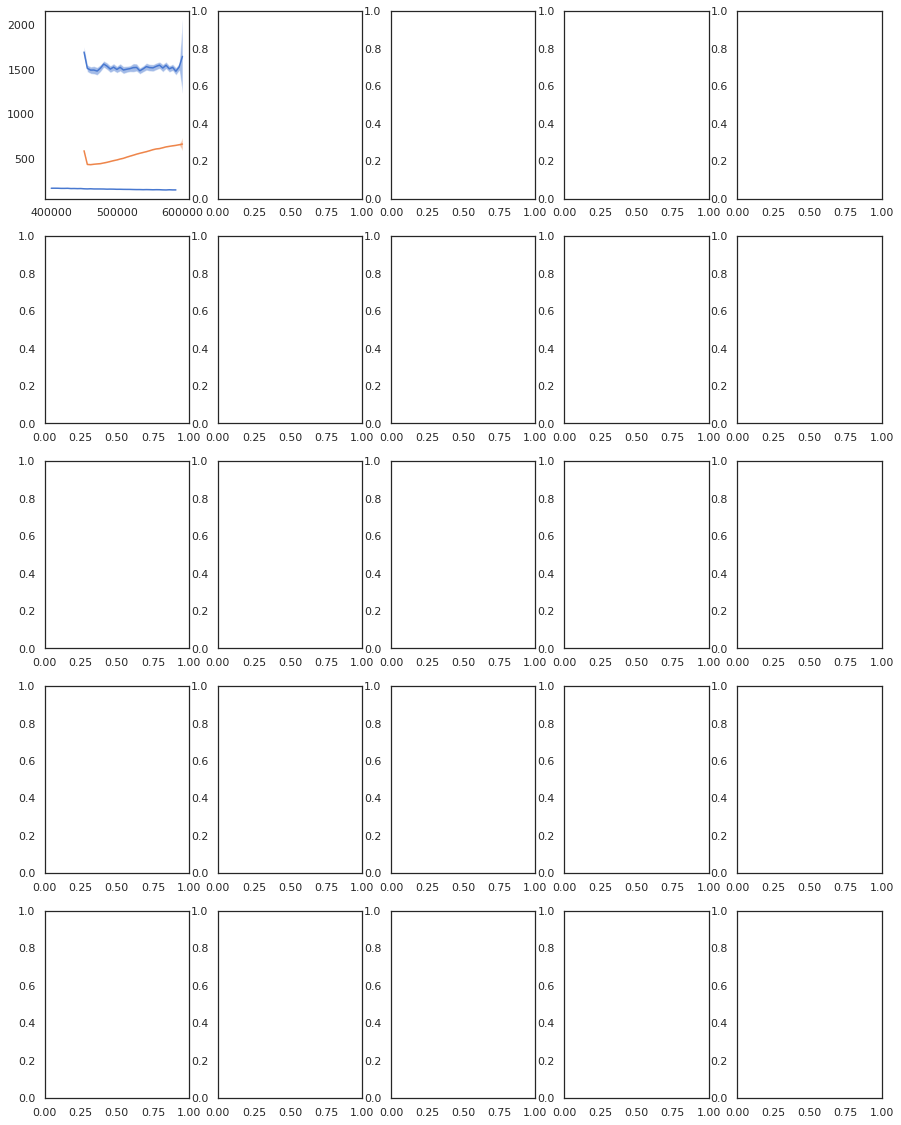

In [731]:
%%time

# plot running train 6 jobs
hue = ['grid_phase', 'job_name']

fig = param_search.plot(
    plot_df[
        #(plot_df['data_phase'] == 'test') &
        #(plot_df['grid_phase'] == 'poster') &
        (
            #(plot_df['group_name'] == '6') |
            (plot_df['job_name'] == 'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65') |
            #(plot_df['job_name'].isin(best_train6_jobs.reset_index()['job_name'])) | 
            (plot_df['job_name'] == best_train4_job)
        ) &
        (plot_df['iteration'] > 400000) &
        (plot_df['iteration'] <= 600000) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(0.00, -0.25),
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
fig.suptitle('Prior improvement CURRENT training plots', y=0.92)
fig.savefig('plots/train6_curr_training_plots.png')

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


CPU times: user 20.7 s, sys: 256 ms, total: 21 s
Wall time: 21 s


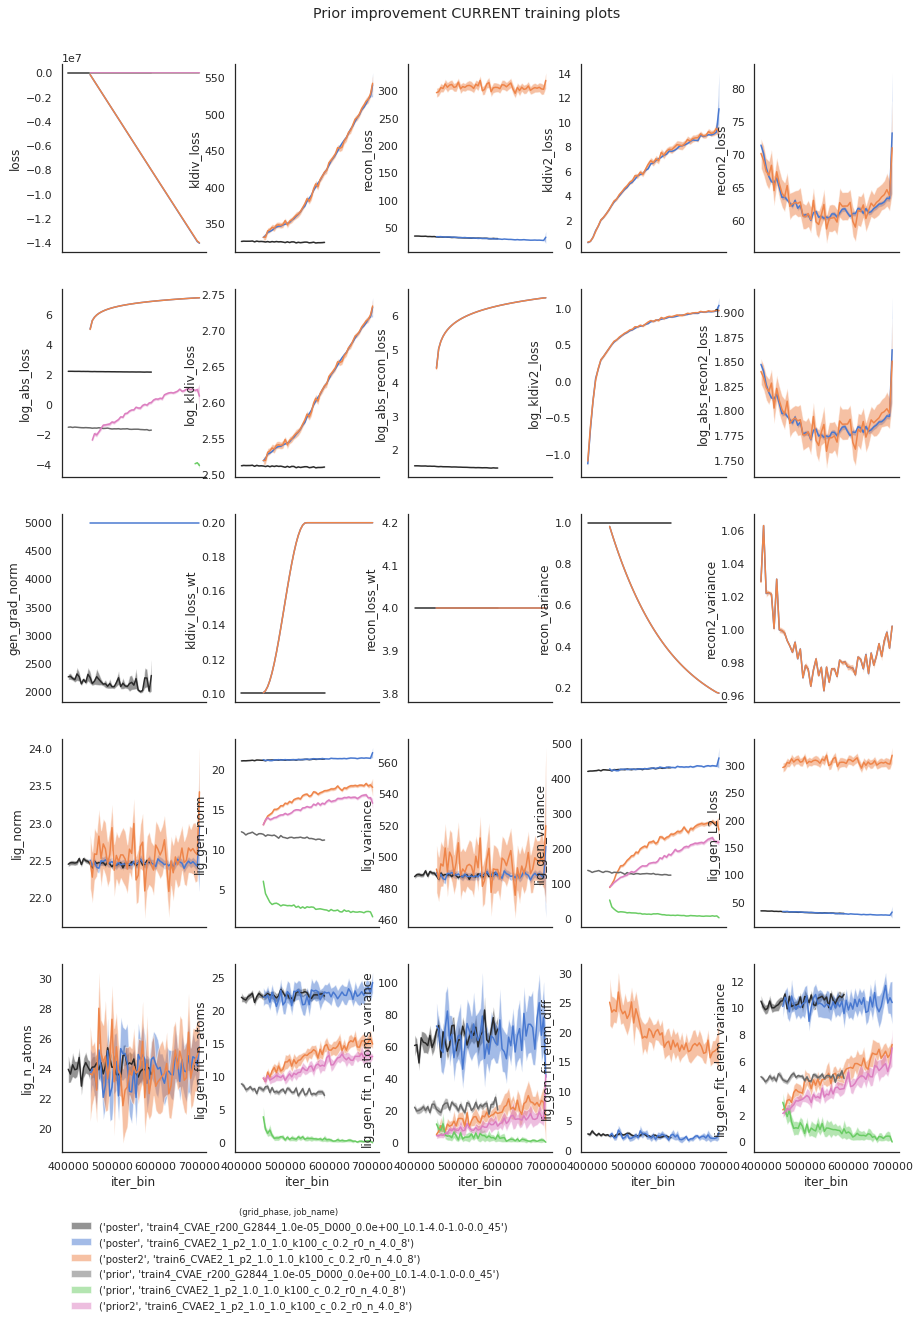

In [723]:
%%time

# plot running train 6 jobs
hue = ['grid_phase', 'job_name']

fig = param_search.plot(
    plot_df[
        #(plot_df['data_phase'] == 'test') &
        #(plot_df['grid_phase'] == 'poster') &
        (
            #(plot_df['group_name'] == '6') |
            (plot_df['job_name'] == 'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8') |
            #(plot_df['job_name'].isin(best_train6_jobs.reset_index()['job_name'])) | 
            (plot_df['job_name'] == best_train4_job)
        ) &
        (plot_df['iteration'] > 400000) &
        (plot_df['iteration'] <= 700000) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(0.00, -0.25),
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
fig.suptitle('Prior improvement CURRENT training plots', y=0.92)
fig.savefig('plots/train6_curr_training_plots.png')

In [472]:
name_format, best_train4_job

('train{group_name}_{model_type}_{learn_recon_var}_p{prior_n_layers}_{kldiv2_loss_start_wt}_{recon2_loss_start_wt}_k{kldiv_loss_period}_{kldiv_loss_sched_type}_{kldiv_loss_end_wt}_r{recon_loss_period}_{recon_loss_sched_type}_{recon_loss_end_wt}_{random_seed}',
 'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45')

In [587]:
%%time

# get average metrics for each job name at each iteration bin
df = train_metrics[
    (train_metrics['data_phase'] == 'test') &
    (train_metrics['iteration'] > 400000)
].groupby(['group_name', 'job_name', 'iter_bin', 'grid_phase']).mean()

# get metrics of best train4 model by iter_bin
best_train4_df = df.loc['4', best_train4_job]

# metrics that we will use to select the best jobs
select_cols = ['lig_gen_fit_n_atoms', 'lig_gen_fit_elem_diff', 'lig_gen_fit_elem_variance']

best_train4_df = best_train4_df[select_cols].unstack().loc[450000]
best_train4_df

CPU times: user 1.08 s, sys: 625 µs, total: 1.08 s
Wall time: 1.08 s


                           grid_phase
lig_gen_fit_n_atoms        poster        22.0560
                           prior          7.9600
lig_gen_fit_elem_diff      poster         2.4440
                           prior             NaN
lig_gen_fit_elem_variance  poster        10.5480
                           prior          4.6424
Name: 450000, dtype: float64

In [614]:
last_train6_df = df.loc['6'].reset_index()

#.groupby(['job_name', 'grid_phase']).last() \
#    .reset_index()
last_train6_df

,job_name,iter_bin,grid_phase,iteration,disc_iter,batch,recon_loss,kldiv_loss,steric_loss,loss,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_n_atoms,lig_radius,lig_gen_fit_type_diff,lig_gen_fit_exact_types,lig_gen_fit_elem_diff,lig_gen_fit_exact_elems,lig_gen_fit_prop_diff,lig_gen_fit_exact_props,lig_gen_fit_atom_rmsd,forward_data_time,forward_gen_time,forward_disc_time,forward_fit_time,forward_metrics_time,memory,forward_time,forward_gpu,gen_grad_norm,backward_grad_time,backward_norm_time,backward_update_time,backward_time,backward_gpu,recon_loss_wt,recon_log_var,kldiv_loss_wt,steric_loss_wt,lig_gen_fit_n_atoms_variance,lig_gen_fit_type_variance,lig_gen_fit_elem_variance,lig_gen_fit_prop_variance,lig_n_atoms_variance,lig_type_variance,lig_elem_variance,lig_prop_variance,batch_size,use_rec_elems,radius_fn,gen_n_filters,gen_conv_per_level,bn_factor,gen_spectral_norm,n_latent,skip_connect,kldiv_loss_start_wt,recon_loss_start_wt,steric_loss_start_wt,gen_lr,gen_grad_clip,disc_grad_clip,n_gen_train_iters,gen_k_iter,random_seed,gen_init_conv_pool,gen_n_levels,growth_rate,width_factor,disc_init_conv_pool,disc_n_levels,disc_conv_per_level,disc_n_filters,n_disc_train_iters,disc_lr,gan_loss_wt,kldiv2_loss,kldiv2_loss_wt,recon2_loss,recon2_loss_wt,recon2_log_var,prior_grad_norm,gan_loss_start_wt,learn_recon_var,prior_n_layers,kldiv2_loss_start_wt,recon2_loss_start_wt,start_iter,kldiv_loss_end_wt,kldiv_loss_period,recon_loss_end_wt,recon_loss_period
0,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,poster,452450.0,0.0,4.0,36.634342,329.042116,0.073996,2.494855e+02,22.691897,437.567612,21.280632,377.903150,36.634342,21.791667,6.203920,23.4250,6.323229,7.558333,0.183333,2.516667,0.316667,5.041667,0.275000,NaN,1.472387,0.045849,0.108547,0.558104,0.003954,14788.215339,2.189941,7197.722578,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.000000,0.100000,1.0,46.965625,28.893750,10.037500,18.856250,71.611458,33.385417,11.666667,21.71875,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.998323,1.0,75.943195,0.5,0.000000,NaN,0.0,0.0,0.0,1.0,0.5,450000.0,0.1,0.0,4.0,0.0
1,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,poster2,452450.0,0.0,4.0,310.711191,327.581041,0.022401,1.344618e+03,22.599290,433.477241,14.448306,118.247033,310.711191,11.000000,3.153866,24.3375,6.159640,58.200000,0.000000,23.012500,0.000000,35.187500,0.000000,NaN,1.330967,0.041994,0.110235,0.327106,0.003770,14789.230625,1.815449,8178.370112,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.000000,0.100000,1.0,7.368750,10.296875,3.631250,6.665625,100.070312,36.443750,11.843750,24.60000,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.324236,1.0,75.336847,0.5,0.000000,NaN,0.0,0.0,0.0,1.0,0.5,450000.0,0.1,0.0,4.0,0.0
2,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,prior,452450.0,0.0,5.0,NaN,NaN,0.038486,3.848642e-02,NaN,NaN,11.840602,116.009681,NaN,8.000000,3.110131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.757957,0.022157,0.084443,0.262372,0.001379,14797.529896,2.130118,8179.563623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.514583,12.858333,4.606250,8.252083,NaN,NaN,NaN,NaN,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.5,450000.0,0.1,0.0,4.0,0.0
3,train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,450000,prior2,452450.0,0.0,5.0,NaN,NaN,0.023007,2.300747e-02,NaN,NaN,14.286020,109.710833,NaN,10.387500,3.020450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.634497,0.022303,0.083391,0.314149,0.001382,14797.479258,2.057536,8179.661401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.892188,8.343750,2.587500,5.756250,NaN,NaN,NaN,NaN,8.0,True,1.0,28.0,4.0,0.0,1.0,128.0,True,0.1,4.0,1.0,0.00001,5000.0,0.0,1.0,580.0,71.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,

In [600]:
# get metrics at last iter_bin of each train6 job
last_train6_df = df.loc['6'].reset_index().groupby(['job_name', 'grid_phase']).last() \
    .reset_index()

last_train6_df = last_train6_df.set_index(['job_name', 'iter_bin', 'grid_phase'])[
    select_cols
].unstack()

last_train6_df['prior_n_atoms'] = np.maximum(
    last_train6_df['lig_gen_fit_n_atoms']['prior'],
    last_train6_df['lig_gen_fit_n_atoms']['prior2'],
)
last_train6_df['prior_stage'] = (
    last_train6_df['lig_gen_fit_n_atoms']['prior2'] > last_train6_df['lig_gen_fit_n_atoms']['prior']
).astype(int) + 1

last_train6_df['poster_elem_diff'] = last_train6_df['lig_gen_fit_elem_diff']['poster']

last_train6_df['prior_increase'] = (
    last_train6_df['prior_n_atoms'] - best_train4_df['lig_gen_fit_n_atoms', 'prior']
)
last_train6_df['recon_decrease'] = (
    last_train6_df['lig_gen_fit_elem_diff', 'poster'] - best_train4_df['lig_gen_fit_elem_diff', 'poster']
)
last_train6_df['total_score'] = last_train6_df['prior_increase'] - last_train6_df['recon_decrease']

last_train6_df.reset_index().set_index(['job_name', 'prior_stage'])[
    ['iter_bin', 'total_score', 'prior_increase', 'recon_decrease', 'prior_n_atoms', 'poster_elem_diff']
].sort_values('total_score', ascending=False)

,,iter_bin,total_score,prior_increase,recon_decrease,prior_n_atoms,poster_elem_diff
,grid_phase,,,,,,
job_name,prior_stage,,,,,,
train6_CVAE2_0_p0_1.0_0.5_k0_n_0.1_r0_n_4.0_71,2,495000,3.942333,4.415000,0.472667,12.375000,2.916667
train6_CVAE2_0_p0_2.0_1.0_k300_r_0.8_r0_n_4.0_19,1,700000,3.800667,4.490000,0.689333,12.450000,3.133333
train6_CVAE2_1_p1_0.5_2.0_k0_n_0.1_r250_d_3.0_47,2,485000,3.452750,3.508750,0.056000,11.468750,2.500000
train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65,1,730000,3.414556,3.762222,0.347667,11.722222,2.791667
train6_CVAE2_0_p1_1.0_2.0_k150_d_0.2_r0_n_4.0_95,2,490000,3.364208,3.274375,-0.089833,11.234375,2.354167
train6_CVAE2_1_p1_1.0_4.0_k0_n_0.1_r0_n_4.0_19,2,710000,3.359000,1.790000,-1.569000,9.750000,0.875000
train6_CVAE2_0_p0_2.0_1.0_k150_c_2.4_r0_n_4.0_59,1,730000,3.350667,6.815000,3.464333,14.775000,5.908333
train6_CVAE2_0_p0_4.0_2.0_k500_d_4.0_r0_n_4.0_78,1,675000,3.317333,5.220556,1.903222,13.180556,4.347222


In [585]:




for metric in select_cols:
    for grid_phase in last_train6_df[c]:
        last_train6_df[(metric,grid_phase)] -= best_train4_df[(metric,grid_phase)]
        
last_train6_df['prior_stage'] -= best_train4_df[('lig_gen_fit_n_atoms','prior')]

best_train6_jobs = last_train6_df[
    (last_train6_df['prior_n_atoms'] > 0) & 
    True
].sort_values(('prior_n_atoms'), ascending=False)
best_train6_jobs

KeyError: ('lig_gen_fit_n_atoms', 'poster2')

In [536]:
bad_train6_jobs = last_train6_df.reset_index().set_index(['job_name', 'iter_bin', 'model_stage']).unstack()
bad_train6_jobs = bad_train6_jobs[
    (
        (bad_train6_jobs['lig_gen_fit_n_atoms']['prior'][1] < 0) &
        (bad_train6_jobs['lig_gen_fit_n_atoms']['prior'][2] < 0)
    ) |
    (bad_train6_jobs['lig_gen_fit_elem_diff']['poster'][1] > 15)
]
bad_train6_jobs

lig_gen_fit_n_atoms  \
grid_phase                                                             poster   
model_stage                                                                 1   
job_name                                         iter_bin                       
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000              3.360000   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000             -0.390000   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000              1.040556   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000              1.297500   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000              0.043333   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000              1.047500   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000              1.255833   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000             -0.490000   
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26 585000             -0.570556   

                                                                      \
grid_phase                                                             
model_stage                                                        2   
job_name                                         iter_bin              
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000   -13.015000   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000    -6.577500   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000    -4.556667   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000    -3.671250   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000   -13.527500   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000   -11.671250   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000   -10.546250   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000   -13.327500   
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26 585000    -7.452500   

                                                                               \
grid_phase                                                    prior             
model_stage                                                       1         2   
job_name                                         iter_bin                       
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000   -1.951667 -0.160000   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000   -7.618333 -3.597500   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000   -8.715556 -1.910000   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000   -8.785000 -6.097500   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000   -7.643333 -1.460000   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000   -8.264167 -0.253750   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000   -7.305833 -0.816250   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000   -3.868333 -0.660000   
train6_CVAE2_1_p0_2.0_2.0_k0_n_0.1_r500_d_2.5_26 585000   -8.590556 -0.680833   

                                                          lig_gen_fit_elem_diff  \
grid_phase                                                               poster   
model_stage                                                                   1   
job_name                                         iter_bin                         
train6_CVAE2_0_p1_4.0_0.5_k0_n_0.1_r250_c_3.0_47 715000               -0.216667   
train6_CVAE2_1_p0_0.5_1.0_k0_n_0.1_r0_n_4.0_43   505000               -0.716667   
train6_CVAE2_1_p0_0.5_2.0_k0_n_0.1_r300_r_1.0_0  680000               -0.480556   
train6_CVAE2_1_p0_0.5_4.0_k0_n_0.1_r500_r_0.5_54 680000               -0.112500   
train6_CVAE2_1_p0_1.0_0.5_k0_n_0.1_r250_d_3.5_21 455000               -0.216667   
train6_CVAE2_1_p0_1.0_0.5_k500_d_4.0_r0_n_4.0_73 580000               -0.112500   
train6_CVAE2_1_p0_1.0_2.0_k500_c_1.6_r0_n_4.0_91 455000                0.116667   
train6_CVAE2_1_p0_2.0_1.0_k100_d_4.0_r0_n_4.0_79 680000               -0.283333   
train6_CVAE2_1_p0

In [542]:
# cancel running train6 jobs that are not promising
cancel_job_ids = train_jobs[
    (train_jobs['job_state'] == 'R') &
    train_jobs['job_name'].isin(bad_train6_jobs.reset_index()['job_name'])
]['job_id'].unique()

param_search.cancel(cancel_job_ids)
len(cancel_job_ids), cancel_job_ids

(9,
 array([6988239, 6988245, 6988287, 6988289, 6988290, 6988300, 6988302,
        6988311, 6988315], dtype=object))

In [30]:
# which of the best train6 jobs are NOT currently running and why?
train_jobs[
    train_jobs['job_name'].isin(best_train6_jobs['job_name']) &
    ~train_jobs['job_name'].isin(running_jobs['job_name']) &
    True
].sort_values(['group_name', 'job_name', 'job_id']).set_index(['group_name', 'job_name', 'job_id'])[
    ['iteration', 'test_recon_loss', 'job_state', 'stderr']
]

iteration  \
group_name job_name                                                            job_id               
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090   206618.0   
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091   205722.0   
                                                                               6971529        NaN   
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165   371125.0   

                                                                                        test_recon_loss  \
group_name job_name                                                            job_id                     
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090              NaN   
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091              NaN   
                                                                               6971529              NaN   
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165              NaN   

                                                                                       job_state  \
group_name job_name                                                            job_id              
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090       ERR   
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091       ERR   
                                                                               6971529        PD   
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165       ERR   

                                                                                                                                                                 stderr  
group_name job_name                                                            job_id                                                                                    
4          train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88 6922090  slurmstepd: error: *** JOB 6922090 ON g015 CANCELLED AT 2021-07-05T23:19:02 ***  
           train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57 6922091  slurmstepd: error: *** JOB 6922091 ON g017 CANCELLED AT 2021-07-05T23:19:02 ***  
                                                                               6971529                                                                             None  
           train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18     6922165  slurmstepd: error: *** JOB 6922165 ON g011 CANCELLED AT 2021-07-05T23:19:02 ***

In [51]:
colors = get_palette(
    n_hues=16,
    n_shades=2,
    mode='husl',
    min_val=0.1,
    max_val=0.9
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.7618514458180183, 0.3609708339002302, 0.43229625732599575),
 (0.9637843654351403, 0.5628421681618326, 0.6346364032287142),
 (0.7592324596036727, 0.38151681310192115, 0.1802169309481654),
 (0.964587691330481, 0.5824618505428452, 0.37715770369882257),
 (0.6381917822622428, 0.45361296434794035, 0.17904750580255635),
 (0.8434745951153879, 0.6554969770437833, 0.374923376667084),
 (0.556825540946517, 0.48704140663235673, 0.17840662320169995),
 (0.7618429025922271, 0.6895256742974988, 0.3711068494528871),
 (0.4750695180000701, 0.5124384666476989, 0.17787585747731377),
 (0.6763278291662416, 0.7171094332674639, 0.359446164329041),
 (0.34820961607050754, 0.5395890587408472, 0.17726522887303223),
 (0.5447435201582534, 0.7445522496214831, 0.36777270200117573),
 (0.18121378837827168, 0.5527949335887479, 0.3310984894514143),
 (0.3735881292586676, 0.757812617054055, 0.5280902666471671),
 (0.18686112847529815, 0.5449136796928328, 0.4482527230943586),
 (0.3784753070652855, 0.7498970432594655, 0.6490918944883306),
 (0.19089357060095424, 0.5389909169908954, 0.5135410808331553),
 (0.3818317640967367, 0.7439243031163321, 0.7172193808207535),
 (0.19495667512302495, 0.5327593061007933, 0.5710795116366396),
 (0.38882834892933305, 0.7367186591938516, 0.7762749050281283),
 (0.20075167650472064, 0.5233838754230236, 0.6438718625927217),
 (0.396613373745806, 0.7266914697042068, 0.8496996700717578),
 (0.29685152664743564, 0.49611383261605313, 0.7508046435423512),
 (0.49591813218923886, 0.6987948215380508, 0.9567819903277834),
 (0.5131113722495746, 0.44270184416593383, 0.7555273367248874),
 (0.7156521542711255, 0.6452727096521343, 0.9565123723657867),
 (0.6618866714069486, 0.3706939187642878, 0.75152812336417),
 (0.866040410141313, 0.5716638979261983, 0.956207027851774),
 (0.7527390687003886, 0.31763221337856823, 0.6830566572816761),
 (0.958148206336938, 0.5174013127029479, 0.8878375055467185),
 (0.7573960764092733, 0.3427985440795964, 0.5631437824457652),
 (0.9612894608678452, 0.5436634925774739, 0.7662638266444659)]

CPU times: user 2min 21s, sys: 47.9 s, total: 3min 9s
Wall time: 4min 14s


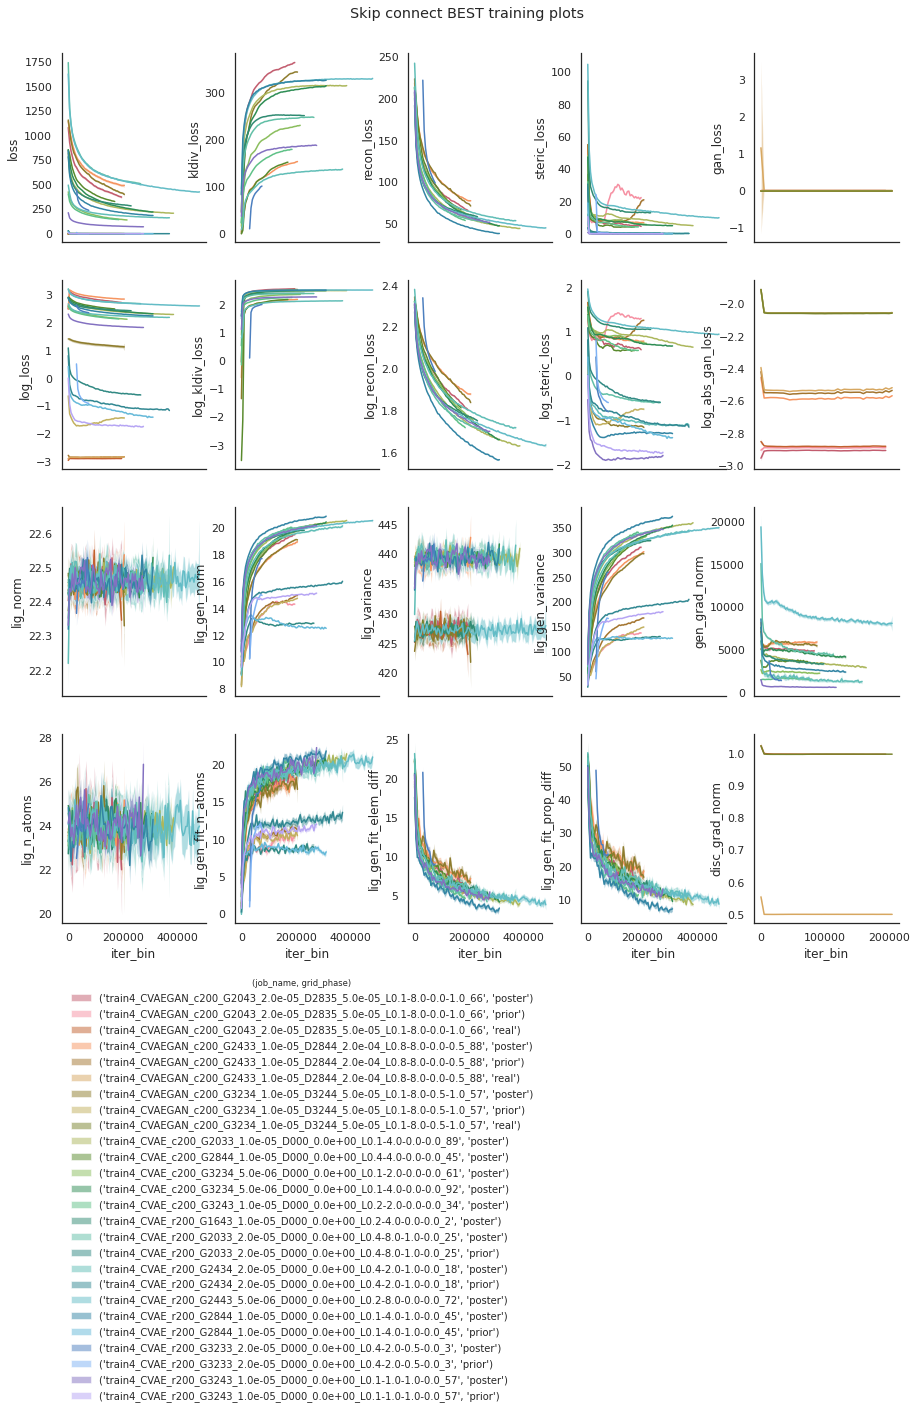

In [52]:
%%time
hue = ['job_name', 'grid_phase']

# plot best train4 job, looking at posterior vs prior
fig = param_search.plot(
    plot_df[
        (plot_df['job_name'].isin(best_train4_jobs['job_name'])) &
        ~(plot_df['recon_loss'] > 300) &
        ~(plot_df['steric_loss'] > 300) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(0.00, -0.25),
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
fig.suptitle('Skip connect BEST training plots', y=0.92)
fig.savefig('plots/train4_best_training_plots.png')

# 5. Test evaluations

Perform inference using trained generative models, using different sampling methods to generate novel molecules.

[Table of contents](#Table-of-contents)

In [465]:
gen_expt_dir = os.path.join(add_expt_dir, 'generate')
os.chdir(gen_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate'

In [191]:
np.random.seed(0)
all_test_pockets = pd.read_csv('../../data/TEST_POCKETS', sep=' ', names=['pocket_name', 'rec_name', 'n_ligands', 'ligands'])
print(all_test_pockets['n_ligands'].describe())

test_targets = all_test_pockets[
    (all_test_pockets['n_ligands'] > 5)
].groupby('pocket_name').sample(1).sample(10)

test_targets.to_csv('SELECTED_TEST_TARGETS', sep=' ', header=False, index=False)
print(test_targets['n_ligands'].sum())
print(len(set(sum((x.split(',') for x in test_targets['ligands']), []))))
test_targets

count    9115.000000
mean       11.576083
std        12.961100
min         1.000000
25%         3.000000
50%         6.000000
75%        16.000000
max        79.000000
Name: n_ligands, dtype: float64
90
89


,pocket_name,rec_name,n_ligands,ligands
935,B4GT1_HUMAN_125_398_0,2ah9_B_rec,6,"bgn,udp,udh,cto,ud2,upg"
4471,KAT2B_HUMAN_715_831_0,5lvq_A_rec,14,"aly,5wv,5wz,2lx,5ws,5wu,2qc,..."
6137,PA2GA_HUMAN_21_144_0,5g3n_A_rec,8,"x28,oap,8in,6in,u8d,bhp,i3n,gel"
3613,G6PI_MOUSE_1_557_0,1u0f_A_rec,6,"g6p,6pg,s6p,der,f6p,a5p"
3279,FABG_PSEAE_1_247_0,4bnw_C_rec,13,"36k,nkh,36i,j2t,fxe,q7u,3x3,..."
2222,CP2B6_HUMAN_20_491_catalytic_0,4i91_A_rec,7,"cpz,85d,cae,sne,tmh,3v4,82s"
7373,PYGL_HUMAN_5_844_0,2ati_A_rec,7,"avf,ave,ihu,055,25d,mrd,avd"
4562,KHK_HUMAN_3_298_0,2hw1_A_rec,11,"tr4,lj9,a4j,tr2,anp,a4g,a3y,..."
4345,INHA_MYCTU_1_269_0,1bvr_C_rec,11,"xt5,tcu,3kx,3ky,2tk,i4i,uud,..."
803,AROK_MYCTU_1_176_0,1zyu_A_rec,7,"adp,skm,anp,acp,s3p,dhk,k2q"


In [156]:
%pwd

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

In [268]:
import param_search
from param_search import params

# define parameter space

base_params = param_search.ParamSpace(
    group_name='0',
    random_seed=0,
    sbatch_line='#SBATCH -C M12|2080Ti',
)

model_params = (
    params.ParamSpace(
        model_type='CVAE',
        prior_n_layers=0,
        train_job_name='train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65',
        train_iter=600000,
    ) + \
    params.ParamSpace(
        model_type='CVAE2',
        prior_n_layers=2,
        train_job_name='train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8',
        train_iter=730000,
    )
)

sample_params = (
    params.ParamSpace( # posterior
        prior=0,
        var_factor=[1.0, 2.0, 4.0, 0.5],
        post_factor=1.0,
        truncate=False,
    ) + \
    params.ParamSpace( # prior
        prior=1,
        var_factor=[1.0, 2.0, 4.0, 0.5],
        post_factor=0.0,
        truncate=False,
    ) + \
    params.ParamSpace( # post/prior interp (will this work for CVAE2?)
        prior=0,
        var_factor=1.0,
        post_factor=[0.8, 0.6, 0.4, 0.2],
        truncate=False,
    )
)

d = []
for i, target in test_targets.iterrows():
    
    d.append(params.ParamSpace(
        pocket_name=target['pocket_name'],
        rec_name=target['rec_name'],
        n_examples=target['n_ligands'],
        n_samples=100,
    ))
    
assert len(d) == 10
data_params = d[0] + d[1] + d[2] + d[3] + d[4] + d[5] + d[6] + d[7] + d[8] + d[9]

gen_params = list(base_params * model_params * sample_params * data_params)

for p in gen_params:
    p['stage2'] = (p['model_type'] == 'CVAE2' and p['prior'])

name_format = 'gen{group_name}_{model_type}_{rec_name}_{prior}_{var_factor}_{post_factor}'

len(gen_params)

240

In [269]:
# estimate evaluation time
n_examples = test_targets['n_ligands'].mean()
n_samples = d[0]['n_samples'][0]
s_per_sample = 10

n_examples * n_samples * s_per_sample / 3600 # hours per job

2.5

In [270]:
# set job submission order
for p in gen_params:
    name = name_format.format(**p)
    print(name)

gen0_CVAE_2ah9_B_rec_0_1.0_1.0
gen0_CVAE_5lvq_A_rec_0_1.0_1.0
gen0_CVAE_5g3n_A_rec_0_1.0_1.0
gen0_CVAE_1u0f_A_rec_0_1.0_1.0
gen0_CVAE_4bnw_C_rec_0_1.0_1.0
gen0_CVAE_4i91_A_rec_0_1.0_1.0
gen0_CVAE_2ati_A_rec_0_1.0_1.0
gen0_CVAE_2hw1_A_rec_0_1.0_1.0
gen0_CVAE_1bvr_C_rec_0_1.0_1.0
gen0_CVAE_1zyu_A_rec_0_1.0_1.0
gen0_CVAE_2ah9_B_rec_0_2.0_1.0
gen0_CVAE_5lvq_A_rec_0_2.0_1.0
gen0_CVAE_5g3n_A_rec_0_2.0_1.0
gen0_CVAE_1u0f_A_rec_0_2.0_1.0
gen0_CVAE_4bnw_C_rec_0_2.0_1.0
gen0_CVAE_4i91_A_rec_0_2.0_1.0
gen0_CVAE_2ati_A_rec_0_2.0_1.0
gen0_CVAE_2hw1_A_rec_0_2.0_1.0
gen0_CVAE_1bvr_C_rec_0_2.0_1.0
gen0_CVAE_1zyu_A_rec_0_2.0_1.0
gen0_CVAE_2ah9_B_rec_0_4.0_1.0
gen0_CVAE_5lvq_A_rec_0_4.0_1.0
gen0_CVAE_5g3n_A_rec_0_4.0_1.0
gen0_CVAE_1u0f_A_rec_0_4.0_1.0
gen0_CVAE_4bnw_C_rec_0_4.0_1.0
gen0_CVAE_4i91_A_rec_0_4.0_1.0
gen0_CVAE_2ati_A_rec_0_4.0_1.0
gen0_CVAE_2hw1_A_rec_0_4.0_1.0
gen0_CVAE_1bvr_C_rec_0_4.0_1.0
gen0_CVAE_1zyu_A_rec_0_4.0_1.0
gen0_CVAE_2ah9_B_rec_0_0.5_1.0
gen0_CVAE_5lvq_A_rec_0_0.5_1.0
gen0_CVA

In [273]:
gen_job_files = []
for template_file in [
    'generate.config', 'generate.sh'
]:
    gen_job_files = param_search.setup(
        expt_dir=gen_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=gen_params,
    )

gen_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_2ah9_B_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_5lvq_A_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_5g3n_A_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_1u0f_A_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_4bnw_C_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_4i91_A_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_2ati_A_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_2hw1_A_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE_1bvr_C_rec_0_1.0_1.0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_

In [277]:
job_ids = param_search.submit(gen_job_files)
print(job_ids)

[7023120, 7023121, 7023122, 7023123, 7023124, 7023125, 7023126, 7023127, 7023128, 7023129, 7023130, 7023131, 7023132, 7023133, 7023134, 7023135, 7023136, 7023137, 7023138, 7023139, 7023140, 7023141, 7023142, 7023143, 7023144, 7023145, 7023146, 7023147, 7023148, 7023149, 7023150, 7023151, 7023152, 7023153, 7023154, 7023155, 7023156, 7023157, 7023158, 7023159, 7023160, 7023161, 7023162, 7023163, 7023164, 7023165, 7023166, 7023167, 7023168, 7023169, 7023170, 7023171, 7023172, 7023173, 7023174, 7023175, 7023176, 7023177, 7023178, 7023179, 7023180, 7023181, 7023182, 7023183, 7023184, 7023185, 7023186, 7023187, 7023188, 7023189, 7023190, 7023191, 7023192, 7023193, 7023194, 7023195, 7023196, 7023197, 7023198, 7023199, 7023200, 7023201, 7023202, 7023203, 7023204, 7023205, 7023206, 7023207, 7023208, 7023209, 7023210, 7023211, 7023212, 7023213, 7023214, 7023215, 7023216, 7023217, 7023218, 7023219, 7023220, 7023221, 7023222, 7023223, 7023224, 7023225, 7023226, 7023227, 7023228, 7023229, 7023230, 

In [570]:
gen_jobs = pd.DataFrame(dict(
    job_id=[
        # first working gen0 submit
        [7023120, 7023121, 7023122, 7023123, 7023124, 7023125, 7023126, 7023127, 7023128, 7023129, 7023130, 7023131, 7023132, 7023133, 7023134, 7023135, 7023136, 7023137, 7023138, 7023139, 7023140, 7023141, 7023142, 7023143, 7023144, 7023145, 7023146, 7023147, 7023148, 7023149, 7023150, 7023151, 7023152, 7023153, 7023154, 7023155, 7023156, 7023157, 7023158, 7023159, 7023160, 7023161, 7023162, 7023163, 7023164, 7023165, 7023166, 7023167, 7023168, 7023169, 7023170, 7023171, 7023172, 7023173, 7023174, 7023175, 7023176, 7023177, 7023178, 7023179, 7023180, 7023181, 7023182, 7023183, 7023184, 7023185, 7023186, 7023187, 7023188, 7023189, 7023190, 7023191, 7023192, 7023193, 7023194, 7023195, 7023196, 7023197, 7023198, 7023199, 7023200, 7023201, 7023202, 7023203, 7023204, 7023205, 7023206, 7023207, 7023208, 7023209, 7023210, 7023211, 7023212, 7023213, 7023214, 7023215, 7023216, 7023217, 7023218, 7023219, 7023220, 7023221, 7023222, 7023223, 7023224, 7023225, 7023226, 7023227, 7023228, 7023229, 7023230, 7023231, 7023232, 7023233, 7023234, 7023235, 7023236, 7023237, 7023238, 7023239, 7023240, 7023241, 7023242, 7023243, 7023244, 7023245, 7023246, 7023247, 7023248, 7023249, 7023250, 7023251, 7023252, 7023253, 7023254, 7023255, 7023256, 7023257, 7023258, 7023259, 7023260, 7023261, 7023262, 7023263, 7023264, 7023265, 7023266, 7023267, 7023268, 7023269, 7023270, 7023271, 7023272, 7023273, 7023274, 7023275, 7023276, 7023277, 7023278, 7023279, 7023280, 7023281, 7023282, 7023283, 7023284, 7023285, 7023286, 7023287, 7023288, 7023289, 7023290, 7023291, 7023292, 7023293, 7023294, 7023295, 7023296, 7023297, 7023298, 7023299, 7023300, 7023301, 7023302, 7023303, 7023304, 7023305, 7023306, 7023307, 7023308, 7023309, 7023310, 7023311, 7023312, 7023313, 7023314, 7023315, 7023316, 7023317, 7023318, 7023319, 7023320, 7023321, 7023322, 7023323, 7023324, 7023325, 7023326, 7023327, 7023328, 7023329, 7023330, 7023331, 7023332, 7023333, 7023334, 7023335, 7023336, 7023337, 7023338, 7023339, 7023340, 7023341, 7023342, 7023343, 7023344, 7023345, 7023346, 7023347, 7023348, 7023349, 7023350, 7023351, 7023352, 7023353, 7023354, 7023355, 7023356, 7023357, 7023358, 7023359],
        # resubmit gen0 error jobs
        [7023396, 7023397, 7023398, 7023399, 7023400, 7023401, 7023402, 7023403, 7023404, 7023405, 7023406, 7023407, 7023408, 7023409, 7023410, 7023411, 7023412, 7023413, 7023414, 7023415, 7023416, 7023417, 7023418, 7023419, 7023420, 7023421, 7023422, 7023423, 7023424, 7023425, 7023426, 7023427, 7023428, 7023429, 7023430, 7023431, 7023432, 7023433, 7023434, 7023435, 7023436, 7023437, 7023438, 7023439, 7023440, 7023441, 7023442, 7023443, 7023444, 7023445, 7023446, 7023447, 7023448, 7023449, 7023450, 7023451, 7023452, 7023453, 7023454, 7023455, 7023456, 7023457, 7023458, 7023459, 7023460, 7023461, 7023462, 7023463, 7023464, 7023465, 7023466, 7023467, 7023468, 7023469, 7023470, 7023471, 7023472, 7023473, 7023474, 7023475, 7023476, 7023477, 7023478, 7023479, 7023480, 7023481, 7023482, 7023483, 7023484, 7023485, 7023486, 7023487, 7023488, 7023489, 7023490, 7023491, 7023492, 7023493, 7023494, 7023495, 7023496, 7023497],
        # resubmit more error jobs (cancelled redundant)
        [7023506, 7023507, 7023508, 7023509, 7023510, 7023511, 7023512, 7023513, 7023514, 7023515, 7023516, 7023517, 7023518, 7023519, 7023520, 7023521, 7023522, 7023523, 7023524, 7023525, 7023526, 7023527, 7023528, 7023529, 7023530, 7023531, 7023532, 7023533, 7023534, 7023535, 7023536, 7023537, 7023538, 7023539, 7023540, 7023541, 7023542, 7023543, 7023544, 7023545, 7023546, 7023547, 7023548, 7023549, 7023550, 7023551, 7023552, 7023553, 7023554, 7023555, 7023556, 7023557, 7023558, 7023559, 7023560, 7023561, 7023562, 7023563, 7023564, 7023565, 7023566, 7023567, 7023568, 7023569, 7023570, 7023571, 7023572, 7023573, 7023574, 7023575, 7023576, 7023577, 7023578, 7023579, 7023580, 7023581, 7023582, 7023583, 7023584, 7023585, 7023586, 7023587, 7023588, 7023589, 7023590, 7023591, 7023592, 7023593, 7023594, 7023595, 7023596, 7023597, 7023598, 7023599, 7023600, 7023601, 7023602, 7023603, 7023604, 7023605, 7023606, 7023607],
        # fix post_factor bug and resubmit affected jobs
        [7023617, 7023618, 7023619, 7023620, 7023621, 7023622, 7023623, 7023624, 7023625, 7023626, 7023627, 7023628, 7023629, 7023630, 7023631, 7023632, 7023633, 7023634, 7023635, 7023636, 7023637, 7023638, 7023639, 7023640, 7023641, 7023642, 7023643, 7023644, 7023645, 7023646, 7023647, 7023648, 7023649, 7023650, 7023651, 7023652, 7023653, 7023654, 7023655, 7023656, 7023657, 7023658, 7023659, 7023660, 7023661, 7023662, 7023663, 7023664, 7023665, 7023666, 7023667, 7023668, 7023669, 7023670, 7023671, 7023672, 7023673, 7023674, 7023675, 7023676, 7023677, 7023678, 7023679, 7023680, 7023681, 7023682, 7023683, 7023684, 7023685, 7023686, 7023687, 7023688, 7023689, 7023690, 7023691, 7023692, 7023693, 7023694, 7023695, 7023696],
    ],
    group_name=[0,0,0,0]
)).explode('job_id')

In [571]:
%%time
import param_search

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

print('Getting queue status')
qstat = param_search.status(job=gen_jobs.job_id)

print('Merging data frames')
gen_jobs = gen_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
gen_jobs['work_dir'] = gen_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
gen_jobs['job_name'] = gen_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
gen_jobs['job_file'] = gen_jobs.apply(lambda x: '{work_dir}/generate.sh'.format(**x), axis=1)
gen_jobs['stdout_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
gen_jobs['stderr_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
gen_jobs['metrics_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_name}.gen_metrics'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 198 ms, sys: 38.2 ms, total: 236 ms
Wall time: 326 ms


In [572]:
%%time

print('Reading stdout files')
gen_jobs['stdout'] = gen_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    output_pat=r'^(\[example_idx=\d+ .+\].*)'
)
print()

print('Reading stderr files')
gen_jobs['stderr'] = gen_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
gen_jobs['job_state'] = gen_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(gen_jobs['job_name'].unique())}
gen_jobs['job_name_idx'] = gen_jobs['job_name'].map(job_name_idx)

Reading stdout files
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Reading stderr files
.................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [573]:
pd.set_option('display.max_rows', 500)
rec_n_ligands = test_targets.set_index('rec_name')['n_ligands']
has = lambda x: not pd.isnull(x)

gen_jobs['rec_name'] = gen_jobs['job_name'].map(
    lambda x: x.split('rec')[0].split('_', 2)[2] + 'rec' if has(x) else x
)
gen_jobs['n_ligands'] = gen_jobs['rec_name'].map(
    lambda x: rec_n_ligands[x] if has(x) else x
)

gen_jobs['example_idx'] = gen_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=(\d+) ', x).group(1)) if has(x) else x
)
gen_jobs['sample_idx'] = gen_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=\d+ sample_idx=(\d+) ', x).group(1)) if has(x) else np.nan
)
gen_jobs['pct_done'] = (gen_jobs['example_idx']*100 + gen_jobs['sample_idx'])/(gen_jobs['n_ligands']*100-1)

gen_jobs['t_left'] = gen_jobs['runtime'].map(as_timedelta) / gen_jobs['pct_done'] * (1-gen_jobs['pct_done'])
gen_jobs['t_left'] = gen_jobs['t_left'].map(lambda x: x.total_seconds() / 3600)

gen_jobs[
    (gen_jobs['group_name'] == 0) &
    (gen_jobs['job_state'] == 'R') &
    True
].set_index(['group_name', 'job_name', 'job_id']).sort_values(['job_name_idx','job_id'])[
    ['queue', 'job_state', 'runtime', 'n_ligands', 'pct_done', 't_left', 'stdout', 'stderr']
]

queue job_state  runtime  n_ligands  pct_done    t_left                           stdout stderr
group_name job_name                        job_id                                                                                                     
0          gen0_CVAE_5lvq_A_rec_1_4.0_0.0  7023404  dept_gpu         R  7:11:23       14.0  0.678342  3.409247  [example_idx=9 sample_idx=49...   None
           gen0_CVAE_5g3n_A_rec_1_4.0_0.0  7023515  dept_gpu         R  5:16:37        8.0  0.989987  0.053370  [example_idx=7 sample_idx=91...   None
           gen0_CVAE_2hw1_A_rec_0_1.0_0.8  7023624  dept_gpu         R  4:59:10       11.0  0.568699  3.781467  [example_idx=6 sample_idx=25...   None
           gen0_CVAE_4bnw_C_rec_0_1.0_0.6  7023631  dept_gpu         R  4:50:36       13.0  0.973826  0.130177  [example_idx=12 sample_idx=6...   None
           gen0_CVAE_4bnw_C_rec_0_1.0_0.4  7023641  dept_gpu         R  4:23:46       13.0  0.827560  0.916027  [example_idx=10 sample_idx=7...   None
           gen0_CVAE_2ati_A_rec_0_1.0_0.4  7023643  dept_gpu         R  4:19:39        7.0  0.994278  0.024906  [example_idx=6 sample_idx=95...   None
           gen0_CVAE_2hw1_A_rec_0_1.0_0.4  7023644  dept_gpu         R  4:19:22       11.0  0.538672  3.702109  [example_idx=5 sample_idx=92...   None
           gen0_CVAE_1bvr_C_rec_0_1.0_0.4  7023645  dept_gpu         R  4:17:04       11.0  0.969063  0.136780  [example_idx=10 sample_idx=6...   None
           gen0_CVAE_4bnw_C_rec_0_1.0_0.2  7023651  dept_gpu         R  3:48:34       13.0  0.795227  0.980941  [example_idx=10 sample_idx=3...   None
           gen0_CVAE_2ati_A_rec_0_1.0_0.2  7023653  dept_gpu         R  3:47:24        7.0  0.683834  1.752280  [example_idx=4 sample_idx=78...   None
           gen0_CVAE_2hw1_A_rec_0_1.0_0.2  7023654  dept_gpu         R  3:45:48       11.0  0.703367  1.587124  [example_idx=7 sample_idx=73...   None
           gen0_CVAE_1bvr_C_rec_0_1.0_0.2  7023655  dept_gpu         R  3:44:00       11.0  0.905369  0.390218  [example_idx=9 sample_idx=95...   None
           gen0_CVAE2_4bnw_C_rec_0_1.0_0.8 7023661  dept_gpu         R  3:31:01       13.0  0.839877  0.670508  [example_idx=10 sample_idx=9...   None
           gen0_CVAE2_2ati_A_rec_0_1.0_0.8 7023663  dept_gpu         R  3:21:03        7.0  0.550787  2.732887  [example_idx=3 sample_idx=85...   None
           gen0_CVAE2_2hw1_A_rec_0_1.0_0.8 7023664  dept_gpu         R  3:14:36       11.0  0.590537  2.248844  [example_idx=6 sample_idx=49...   None
           gen0_CVAE2_1bvr_C_rec_0_1.0_0.8 7023665  dept_gpu         R  3:14:22       11.0  0.632393  1.883073  [example_idx=6 sample_idx=95...   None
           gen0_CVAE2_4bnw_C_rec_0_1.0_0.6 7023671  dept_gpu         R  3:03:21       13.0  0.752887  1.002988  [example_idx=9 sample_idx=78...   None
           gen0_CVAE2_2ati_A_rec_0_1.0_0.6 7023673  dept_gpu         R  2:48:27        7.0  0.781116  0.786717  [example_idx=5 sample_idx=46...   None
           gen0_CVAE2_2hw1_A_rec_0_1.0_0.6 7023674  dept_gpu         R  2:43:25       11.0  0.517743  2.536931  [example_idx=5 sample_idx=69...   None
           gen0_CVAE2_1bvr_C_rec_0_1.0_0.6 7023675  dept_gpu         R  2:35:50       11.0  0.717925  1.020455  [example_idx=7 sample_idx=89...   None
           gen0_CVAE2_4bnw_C_rec_0_1.0_0.4 7023681  dept_gpu         R  2:24:28       13.0  0.679754  1.134355  [example_idx=8 sample_idx=83...   None
           gen0_CVAE2_2ati_A_rec_0_1.0_0.4 7023683  dept_gpu         R  2:21:11        7.0  0.530758  2.080329  [example_idx=3 sample_idx=71...   None
           gen0_CVAE2_2hw1_A_rec_0_1.0_0.4 7023684  dept_gpu         R  2:18:59       11.0  0.497725  2.337562  [example_idx=5 sample_idx=47...   None
           gen0_CVAE2_1bvr_C_rec_0_1.0_0.4 7023685  dept_gpu         R  2:17:50       11.0  0.945405  0.132660  [example_idx=10 sample_idx=3...   None
           gen0_CVAE2_2ati_A_rec_0_1.0_0.2 7023693  dept_gpu         R  1:52:15        7.0  0.988555  0.021659  [example_idx=6 sa

In [565]:
# resubmit jobs with intermediate post_factor != 0.0 or 1.0
#   since it was not getting pass in correctly, defaulted to 1.0
resub_jobs = gen_jobs[
    gen_jobs['job_name'].map(lambda x: float(x.rsplit('_', 1)[1]) not in {0.0, 1.0} if x else False)
]

resub_jobs #job_ids = param_search.submit(resub_jobs['job_file'].unique()); repr(job_ids)
repr(job_ids)

'[7023617, 7023618, 7023619, 7023620, 7023621, 7023622, 7023623, 7023624, 7023625, 7023626, 7023627, 7023628, 7023629, 7023630, 7023631, 7023632, 7023633, 7023634, 7023635, 7023636, 7023637, 7023638, 7023639, 7023640, 7023641, 7023642, 7023643, 7023644, 7023645, 7023646, 7023647, 7023648, 7023649, 7023650, 7023651, 7023652, 7023653, 7023654, 7023655, 7023656, 7023657, 7023658, 7023659, 7023660, 7023661, 7023662, 7023663, 7023664, 7023665, 7023666, 7023667, 7023668, 7023669, 7023670, 7023671, 7023672, 7023673, 7023674, 7023675, 7023676, 7023677, 7023678, 7023679, 7023680, 7023681, 7023682, 7023683, 7023684, 7023685, 7023686, 7023687, 7023688, 7023689, 7023690, 7023691, 7023692, 7023693, 7023694, 7023695, 7023696]'

In [520]:
# resubmit jobs whose latest submission errored out
error_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'ERR')
error_jobs = error_jobs[error_jobs ] # drop non-error jobs

error_jobs = gen_jobs[
    gen_jobs['job_name'].isin(error_jobs.index)
]
error_jobs #param_search.submit(error_jobs['job_file'].unique())

,job_id,group_name,queue,job_name,user,...,n_ligands,example_idx,sample_idx,pct_done,t_left


In [ ]:
%%time
# read in test generative metrics for completed jobs

# resubmit jobs whose latest submission errored out
done_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'OK')
done_jobs = done_jobs[done_jobs ] # drop incomplete jobs

done_jobs = gen_jobs[
    gen_jobs['job_name'].isin(done_jobs.index)
]

gen_metrics = param_search.metrics(done_jobs.reset_index()['job_file'].unique())

In [554]:
gen_param_cols = ['model_type', 'rec_name', 'post_factor', 'var_factor']

gen_metrics.groupby(gen_param_cols)[
    ['lig_valid', 'lig_gen_fit_add_valid', 'lig_gen_fit_n_atoms', 'lig_gen_fit_type_diff']
].mean()

lig_valid  lig_gen_fit_add_valid  lig_gen_fit_n_atoms  lig_gen_fit_type_diff
model_type rec_name   post_factor var_factor                                                                              
CVAE       1bvr_C_rec 0.0         0.5               1.0               0.961818            11.205455              66.070909
                                  1.0               1.0               0.870000            15.961818              51.881818
                                  2.0               1.0               0.460909            25.716364              44.610909
                      0.2         1.0               1.0               0.981818            23.026364              17.892727
                      0.6         1.0               1.0               0.980909            23.043636              17.830000
                      1.0         0.5               1.0               0.980909            23.491818              15.806364
                                  1.0               1.0               0.981818            23.027273              17.891818
                                  2.0               1.0               0.943636            22.740000              23.290000
                                  4.0               1.0               0.684545            25.640909              32.001818
           1u0f_A_rec 0.0         0.5               1.0               0.985000            11.435000              23.486667
                                  1.0               1.0               0.945000            13.751667              26.965000
                                  2.0               1.0               0.421667            20.665000              53.936667
                      0.2         1.0               1.0               1.000000            14.640000               4.480000
                      0.4         1.0               1.0               1.000000            14.638333               4.485000
                      0.6         1.0               1.0               1.000000            14.640000               4.480000
                      0.8         1.0               1.0               1.000000            14.640000               4.480000
                      1.0         0.5               1.0               1.000000            14.736667               3.021667
                                  1.0               1.0               1.000000            14.640000               4.480000
                                  2.0               1.0               0.988333            14.620000              14.316667
                                  4.0               1.0               0.586667            16.928333              36.033333
           1zyu_A_rec 0.0         0.5               1.0               0.987143            10.285714              44.788571
                                  1.0               1.0               0.921429            13.170000              41.815714
                      0.2         1.0               1.0               0.990000            19.180000               8.221429
                      0.4         1.0               1.0               0.988571            19.182857               8.212857
                      0.6         1.0               1.0               0.990000            19.170000               8.237143
                      0.8         1.0               1.0               0.988571            19.175714               8.220000
                      1.0         0.5               1.0               0.998571            19.367143               6.637143
                                  1.0               1.0               0.990000            19.182857               8.198571
                                  2.0               1.0               0.958571            18.621429              17.667143
                                  4.0               1.0               0.587143            20.140000              36.952857
           2ah9_B_rec 0.0         0.5               1.0               0.985000            10.868333           